<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos</p>
<p style="margin: 0; text-align:right;">2022-1 · Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PEC 3: Métodos supervisados

En esta práctica veremos diferentes métodos supervisados y trataremos de optimizar diferentes métricas. Veremos como los diferentes modelos clasifican los puntos y con cuales obtenemos mayor precisión. Después aplicaremos todo lo que hemos aprendido hasta ahora a un dataset nuevo simulando un caso práctico real.

1. [Exploración de algoritmos supervisados](#ej1)
        1.0. Carga de datos
        1.1. Naive-Bayes
        1.2. K vecinos más próximos
        1.3. Support vector machines
        1.4. Árboles de decisión
        1.5. Random forest / Gradient boosting
2. [Implementación del caso práctico](#ej2)
        2.0. Carga de datos
        2.1. Preprocesamiento de los datos
        2.2. Análisis descriptivo
        2.3. Entrenamiento del modelo
        2.4. Predicción de nuevos casos
        2.5. BONUS

<u>Consideraciones generales</u>: 

- La solución planteada no puede utilizar métodos, funciones o parámetros declarados **_deprecated_** en futuras versiones, a excepción de la carga de datos cómo se indica posteriormente.
- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

<div class="alert alert-block alert-info">
    <strong>Nombre y apellidos:</strong>
</div>

In [1]:
from collections import Counter
import json
import re

import nltk
import numpy as np 
import pandas as pd
import pickle
import seaborn as sns

from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# UMAP para la reducción de dimensionalidad
import umap

# Visualización.
from dtreeviz.trees import dtreeviz
import graphviz
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

%matplotlib inline

nltk.download('stopwords');

/home/geviar/anaconda3/envs/uoc20221pec3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/geviar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id='ej1'></a>
# 1. Exploración de algoritmos supervisados

## 1.0. Carga de datos

El conjunto de datos Fashion MNIST proporcionado por Zalando consta de 70.000 imágenes con 10 clases diferentes de ropa repartidas uniformemente. No obstante, para esta práctica utilizaremos únicamente un subconjunto de 5.000 imágenes que consiste en 1.000 imágenes de 5 clases diferentes.

Las imágenes tienen una resolución de 28x28 píxeles en escala de grises, por lo que se pueden representar utilizando un vector de 784 posiciones.

El siguiente código cargará las 5.000 imágenes en la variable images y las correspondientes etiquetas (en forma numérica) en la variable labels. Podemos comprobar que la carga ha sido correcta obteniendo las dimensiones de estas dos variables.

In [2]:
with open("data.pickle", "rb") as f:
    data = pickle.load(f)
    
X = data["images"]
y = data["labels"]
n_classes = 5
labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat"]

print("Dimensiones del vector de imágenes: {}".format(X.shape))
print("Dimensiones del vector de etiquetas: {}".format(y.shape))

Dimensiones del vector de imágenes: (5000, 784)
Dimensiones del vector de etiquetas: (5000,)


Con el siguiente código podemos ver un ejemplo de imagen de cada una de las clases. Para ello reajustamos el vector de 784 dimensiones que representa cada imagen en una matriz de tamaño 28x28 y la transponemos para mostrarla:

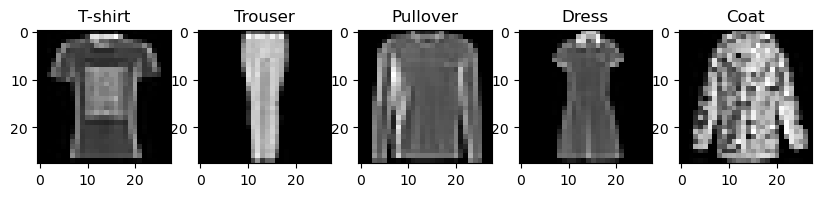

In [3]:
fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(y == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(X[k].reshape(28, 28), cmap="gray")
    ax[i].set_title("{}".format(labels[i]))

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> 

Dividid el _dataset_ en dos subconjuntos, __*train*__ (80% de los datos) y __*test*__ (20% de los datos). Nombrad los conjuntos como: X_train, X_test, y_train, y_test. Utilizad la opción `random_state = 24`.
    
Podéis utilizar la implementación `train_test_split` de `sklearn`.
    
</div>

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
print(f'Train size: {X_train.shape[0]} Test size: {X_test.shape[0]}')

Train size: 4000 Test size: 1000


Para poder visualizar los resultados de cada algoritmo supervisado, reduciremos el dataset anterior a dos dimensiones.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


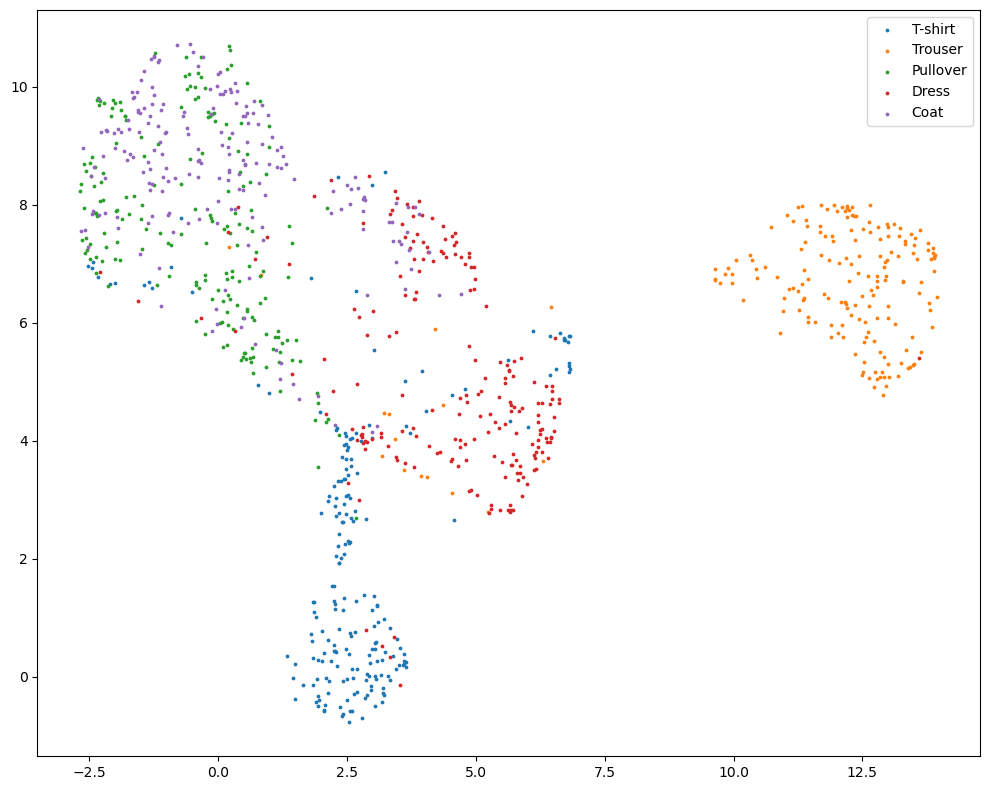

In [5]:
model = umap.UMAP(n_components=2, random_state=42)
model.fit(X_train)
X_train_projection = model.transform(X_train)
X_test_projection = model.transform(X_test)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i in range(n_classes):
    ax.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], s=3, label=labels[i])
plt.legend()
plt.tight_layout()

A lo largo de los ejercicios aprenderemos a ver gráficamente las fronteras de decisión que nos devuelven los diferentes modelos. Para ello utilizaremos la función definida a continuación, que sigue los siguientes pasos:

   - Crear una [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) con los valores mínimo y máximo de 'x' e 'y'.
   - Predecir el clasificador con los valores de la _meshgrid_.
   - Hacer un _reshape_ de los datos para tener el formato correspondiente.
  
Una vez hecho esto, ya podemos hacer el gráfico de las fronteras de decisión y añadir los puntos reales. Así veremos las áreas que el modelo considera que son de una clase y las que considera que son de otra. Al poner encima los puntos veremos si los clasifica correctamente en el área que les corresponde.

In [6]:
# vamos a crear la meshgrid con los valores mínimos y máximos de los ejes x e y
x_min, x_max = X_test_projection[:, 0].min() - 1, X_test_projection[:, 0].max() + 1
y_min, y_max = X_test_projection[:, 1].min() - 1, X_test_projection[:, 1].max() + 1

# definimos la función que visualizará la frontera de decisión
def plot_decision_boundaries(model, X_test_projection, y_test):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))
    
    # precedimos con el clasificador con los valores de la meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # definimos los colores (uno para cada clase)
    cmap_light = ListedColormap(['gainsboro','lightgreen','peachpuff','lightcyan', 'pink'])
    cmap_bold = ['grey','g','sandybrown','c','palevioletred']
    
    # dibujamos las fronteras
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20,10))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # dibujamos los puntos
    for i in range(n_classes):
        plt.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], 
                    s=3, label=labels[i], c=cmap_bold[i])
    plt.legend()
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())  

In [7]:
# Set Seaborn aesthetics
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titlelocation'] = 'left'
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1.1. Gaussian Naïve Bayes

El objetivo de este primer ejercicio es entender el funcionamiento del algoritmo Naïve-Bayes, un algoritmo peculiar ya que se basa completamente en teoría de probabilidades.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Con el dataset de _train_, entrenad un modelo Naïve-Bayes y representad gráficamente la frontera de decisión con el de _test_. Podéis utilizar el clasificador **GaussianNB** de `sklearn`.
    
Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_ y la matriz de confusión sobre _test_. Podéis utilizar `accuracy_score` y `confusion_matrix` del paquet `metrics` de `sklearn`.
</div>

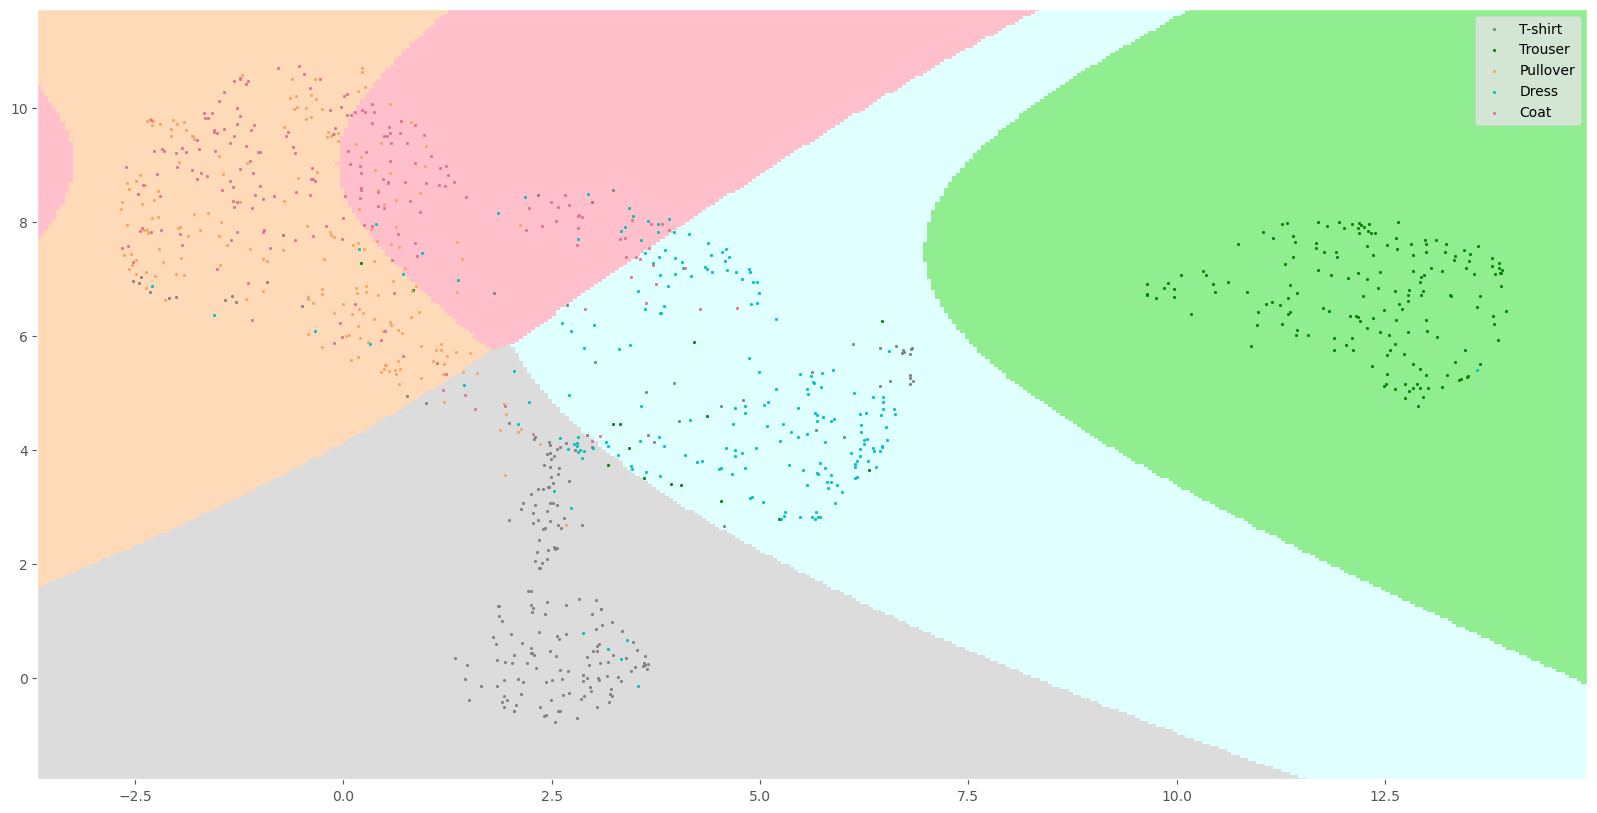

In [8]:
NB = GaussianNB().fit(X_train_projection, y_train)
plot_decision_boundaries(NB, X_test_projection, y_test)

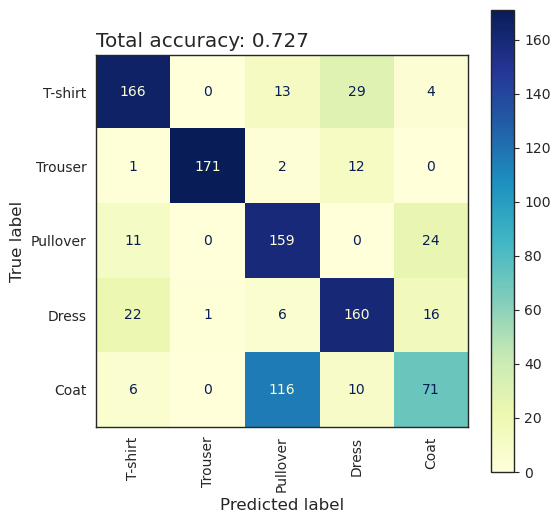

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

def show_cf_accuracy(estimator, X_test, y_test, labels):
    y_pred = estimator.predict(X_test)
    cf = confusion_matrix(y_test, y_pred)
    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(6, 6))
    cf_display = ConfusionMatrixDisplay(cf, display_labels=labels).plot(ax=ax, xticks_rotation='vertical', cmap='YlGnBu')
    cf_display.ax_.set_title(f'Total accuracy: {accuracy_score(y_test, y_pred):.3f}')
    plt.show()


show_cf_accuracy(NB, X_test_projection, y_test, labels)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 
  
Análisis del ejercicio.

   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

Vemos que las fronteras de decisión con el algoritmo Naive Bayes son suaves, lo cual tiene sentido en este algoritmo, y dividen el espacio de dos dimensiones en 5 regiones.

En cuanto a las predicciones podemos observar como el algoritmo tiene un rendimiento relativamente bueno para tratarse de un modelo tan sencillo, con una precisión de casi el 73%. En todo caso, y viendo las fronteras de decisión, podemos intuir que este modelo es demasiado sencillo para las complejas fronteras que dormasn las distintas clases. También hay que tener en cuenta que hemos reducido la dimensionalidad de forma excepcional hasta sólo dos componentes, por lo que es de esperar que haya mucha información sobre los datos originales que se haya perdido; por otro lado, estamos seguros de cumplir con la condición de independencia de las variables que nos impone el algoritmo.

En cuanto a los errores que se cometen, vemos que son en general bastante bajos, a excepción de los abrigos, que muchos de ellos son categorizados como jerseys, lo cual tiene sentido, ya que ambas prendas tienden a parecerse bastante. En la representación de dos dimensiones de estos datos ya podemos ver como los puntos de estas dos categorías están muy mezclados, por lo que es de esperar que el algoritmo tenga problemas para diferenciarlos.

### 1.2. KNN

El objetivo de este segundo ejercicio es entender el funcionamiento del KNN, intuir sus principales ventajas o desventajas y entender la influencia de los parámetros de los que está compuesto.

K-Nearest-Neighbor es un algoritmo basado en instancia de tipo supervisado. 

Vamos a ver qué significa esto:

  - Supervisado: tenemos etiquetado nuestro conjunto de datos de entrenamiento, con la clase o resultado esperado.
  - Basado en instancia (_Lazy Learning_): Esto significa que nuestro algoritmo no aprende explícitamente un modelo (como por ejemplo en Regresión Logística o árboles de decisión), sino que memoriza las instancias de entrenamiento que son utilizadas como "conocimiento" para la fase de predicción.

¿Cómo funciona KNN?

  - Calculamos la distancia entre el ítem a clasificar y los demás ítems del dataset de entrenamiento.
  - Seleccionamos los "k" elementos más cercanos, es decir, con menor distancia, según la distancia que utilizamos (euclídea, coseno, manhattan, etc).
  - Por último realizamos una "votación de mayoría" entre los k puntos: los de la clase que "dominan" decidirán su clasificación final.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Con el dataset de _train_, entrenad un modelo KNN con `n_neighbors = 2` y representad gráficamente la frontera de decisión con el de _test_.
    
Podéis utilizar el clasificador **KNeighborsClassifier** de `sklearn`.
</div>

Con Naive Bayes la normalización de los datos de entrada no era necesaria, pero sí lo es para KNN, ya que datos de entrada en distintas escalas producen resultados no deseados. Aunque en este caso los datos de entrada es la proyección UMAP de los datos riginales y deberían estar en una escala similar, siempre es buena práctica realizar una nomalización o estandarización de estos para asegurarnos un comportamiento óptimo del algoritmo.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

KNN_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('clf', KNeighborsClassifier(n_neighbors=2))])
KNN_pipe.fit(X_train_projection, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', KNeighborsClassifier(n_neighbors=2))])

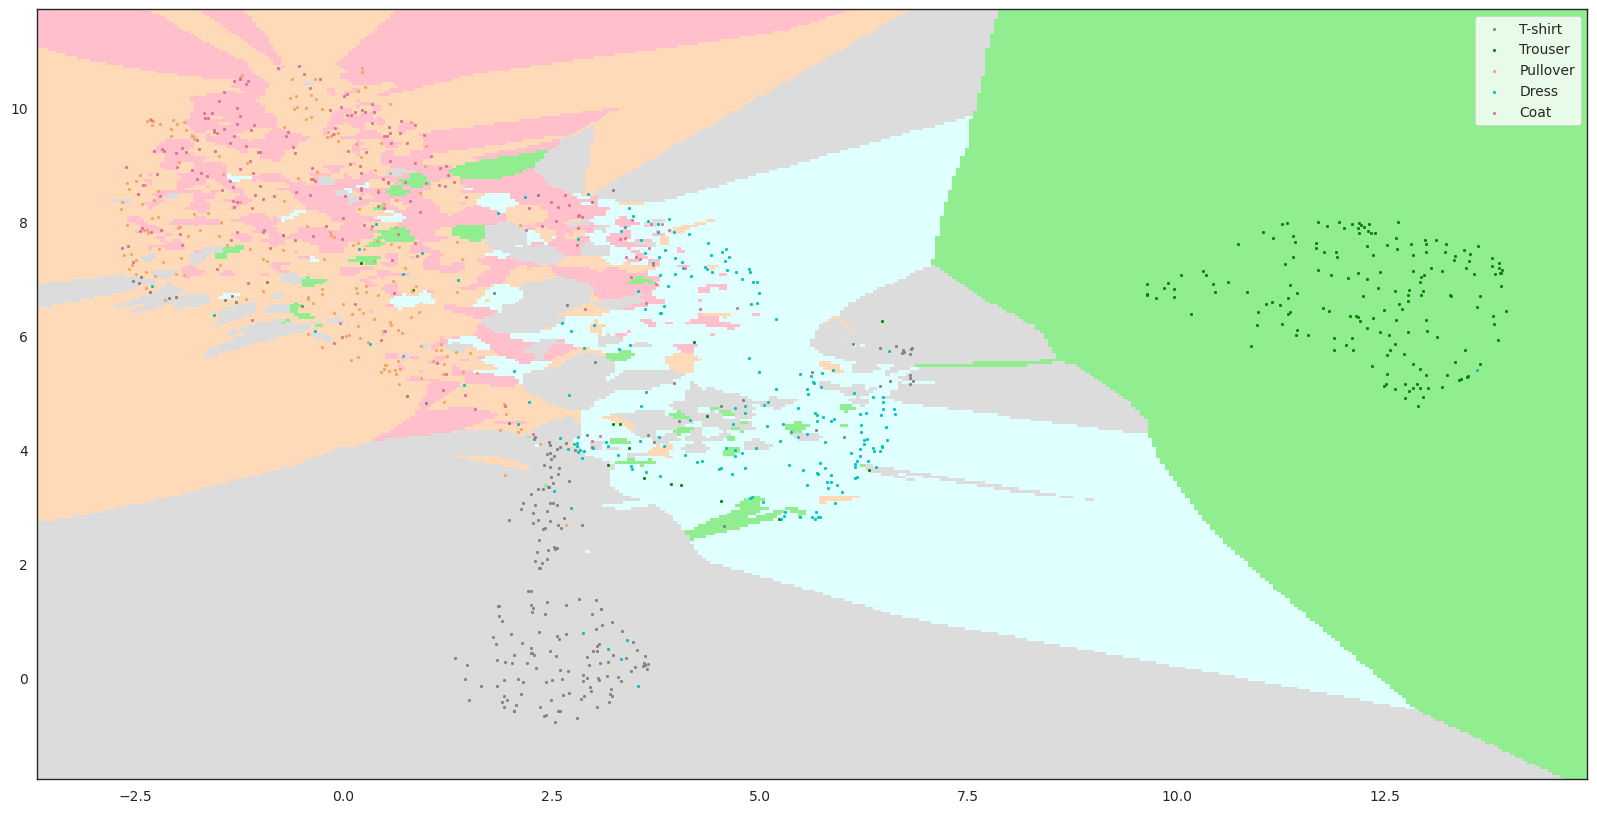

In [11]:
plot_decision_boundaries(KNN_pipe, X_test_projection, y_test)

En el modelo entrenado, hemos fijado el parámetro `n_neighbors` de forma arbitraria. Pero podría ser que con otro valor obtuviéramos una mejor predicción.

Para conocer el valor óptimo de los parámetros de un modelo (_hyperparameter tunning_) se suele utilizar una búsqueda de rejilla (_grid search_). Es decir, entrenar un modelo para cada combinación de hiperparámetros posible y evaluarlo utilizando validación cruzada (_cross validation_) con 4 particiones estratificadas. Posteriormente, se elige la combinación de hiperparàmetres que mejores resultados haya obtenido.

En este caso sólo queremos optimizar un hiperparámetro:

   - 𝑘: el número de vecinos que se consideran para clasificar un nuevo ejemplo. Probaremos con todos los valores entre 1 y 10.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

Cálculo del valor óptimo del hiperparámetro _k_ (`n_neighbors`). Utilizad una búsqueda de rejilla con validación cruzada para encontrar el valor óptimo de _k_. Por cada valor, calculad su promedio y la desviación estándar. Implementad un _heatmap_ para visualizar la precisión según los diferentes valores del hiperparámetro.
    
Puede utilizar el módulo `GridSearchCV` de `sklearn` el cálculo del mejor hiperparámetro, y `heatmap` de `Seaborn`.
</div>

In [12]:
knn_gs = {"clf__n_neighbors": range(1, 10)}

gs_knn = GridSearchCV(KNN_pipe, param_grid=knn_gs, cv=4, n_jobs=-1)
gs_knn.fit(X_train_projection, y_train)
knn_gs_results = pd.DataFrame(gs_knn.cv_results_)
knn_gs_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005140,0.004239,0.032134,0.007581,1,{'clf__n_neighbors': 1},0.760,0.762,0.756,0.742,0.75500,0.007810,8
1,0.002645,0.000297,0.029099,0.001957,2,{'clf__n_neighbors': 2},0.745,0.768,0.746,0.754,0.75325,0.009203,9
2,0.002951,0.000769,0.038041,0.003980,3,{'clf__n_neighbors': 3},0.777,0.807,0.787,0.788,0.78975,0.010848,6
3,0.006731,0.004816,0.030037,0.004423,4,{'clf__n_neighbors': 4},0.785,0.796,0.791,0.786,0.78950,0.004387,7
4,0.002133,0.000033,0.033327,0.010251,5,{'clf__n_neighbors': 5},0.785,0.813,0.803,0.793,0.79850,0.010524,4
5,0.002370,0.000230,0.039864,0.006384,6,{'clf__n_neighbors': 6},0.779,0.808,0.794,0.796,0.79425,0.010305,5
6,0.002328,0.000288,0.034469,0.003421,7,{'clf__n_neighbors': 7},0.780,0.818,0.806,0.807,0.80275,0.013953,2
7,0.002377,0.000290,0.044168,0.010010,8,{'clf__n_neighbors': 8},0.786,0.805,0.799,0.809,0.79975,0.008700,3
8,0.002369,0.000296,0.040704,0.011163,9,{'clf__n_neighbors': 9},0.792,0.805,0.804,0.814,0.80375,0.007822,1


In [13]:
print(f'Best KNN params are: {gs_knn.best_params_}')

Best KNN params are: {'clf__n_neighbors': 9}


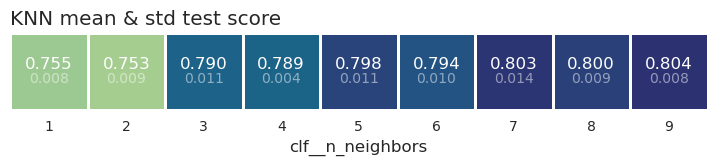

In [14]:
def plot_hm_params(gs_results: pd.DataFrame, name:str):
    params = [param for param in gs_results.columns if param.startswith('param_')]
    if len(params) == 1:
        mean = gs_results[['mean_test_score', params[0]]].set_index(params[0]).T
        std = gs_results[['std_test_score', params[0]]].set_index(params[0]).T
        sizey = 1
    elif len(params) == 2:
        mean = gs_results.pivot(index=params[0], columns=params[1], values='mean_test_score')
        std = gs_results.pivot(index=params[0], columns=params[1], values='std_test_score')
    else:
        print('Cannot plot heatmap for more than 2 hyperparameters')
        raise ValueError
    
    fig, ax = plt.subplots(figsize=(mean.shape[1], mean.shape[0]))
    
    sns.heatmap(mean, annot=std, annot_kws={'va':'top', 'alpha':0.5, 'size':10, 'color':'white'}, fmt='.3f', cbar=False, ax=ax)
    sns.heatmap(mean, annot=True, annot_kws={'va':'bottom', 'size':12, 'color':'white'}, fmt='.3f', linewidths=1, cbar=False, cmap="crest", ax=ax)
    
    if len(params) == 1:
        ax.set_yticklabels('')
        ax.set_xlabel(params[0].replace('param_', ''))
    else:
        ax.set_xlabel(params[1].replace('param_', ''))
        ax.set_ylabel(params[0].replace('param_', ''))
    ax.set_title(f'{name} mean & std test score')
    plt.show()


plot_hm_params(knn_gs_results, 'KNN')

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Con el mejor hiperparámetro encontrado, volved a entrenar un clasificador KNN (con _train_) y representar las fronteras de decisión con los puntos de _test_.
    
Calcular el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusión. Podéis utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.
</div>

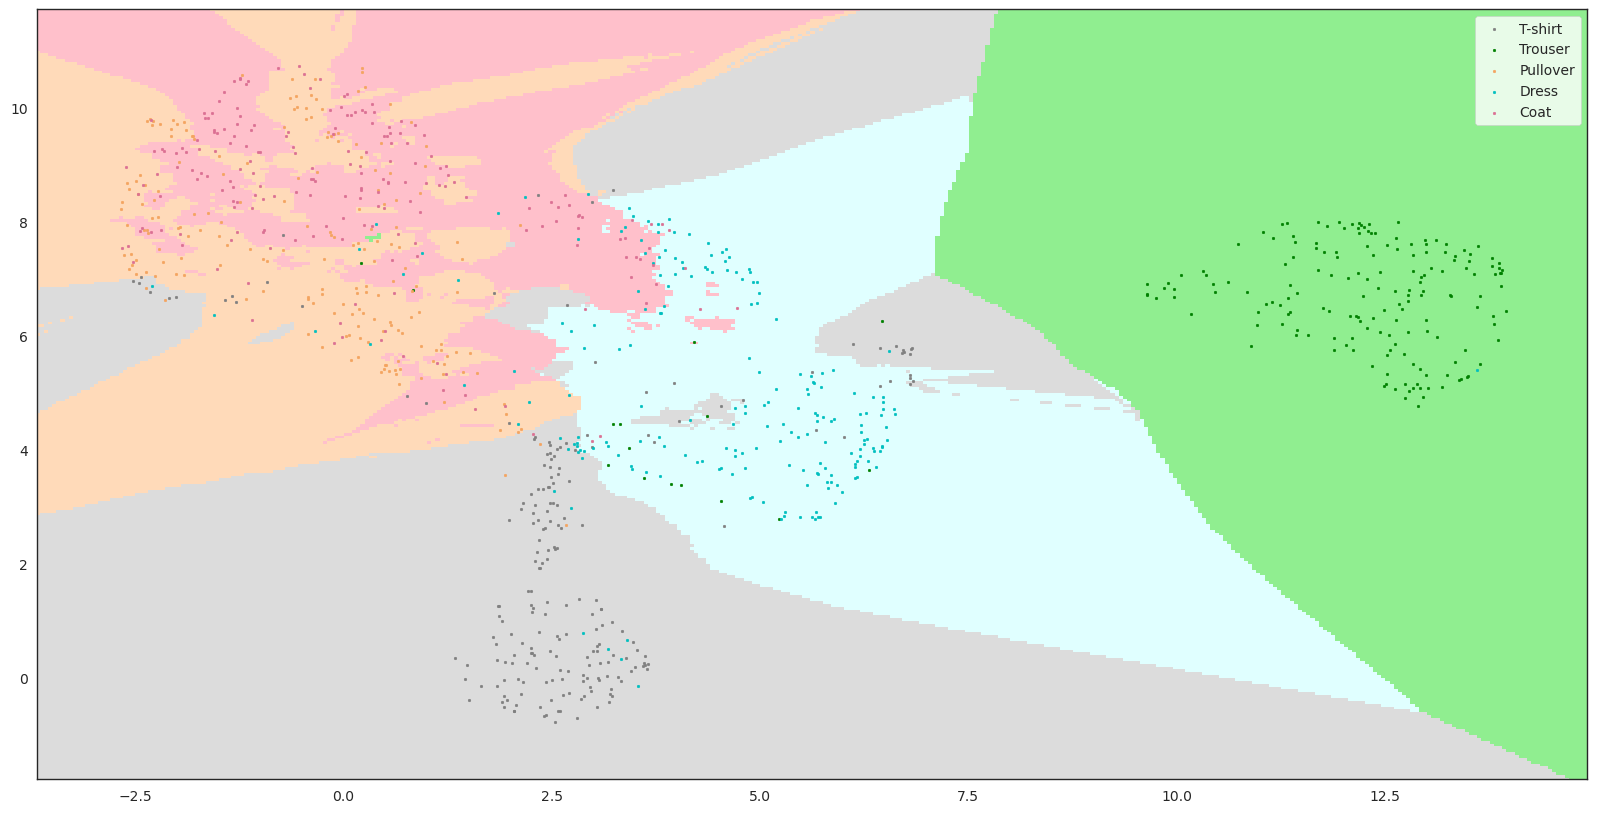

In [15]:
final_knn = gs_knn.best_estimator_.fit(X_train_projection, y_train)
plot_decision_boundaries(final_knn, X_test_projection, y_test)

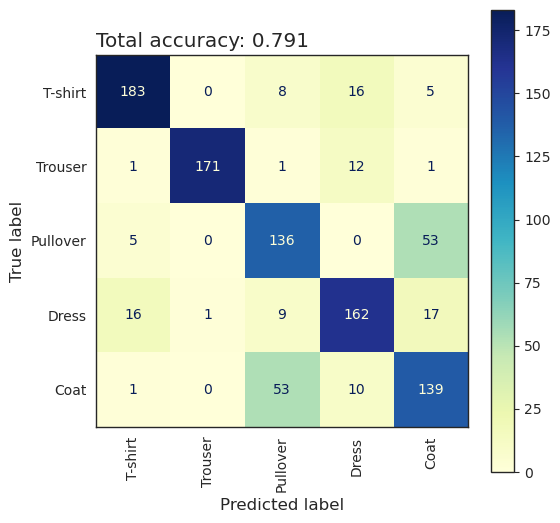

In [16]:
show_cf_accuracy(final_knn, X_test_projection, y_test, labels)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

Análisis del ejercicio:

   - Comentar los resultados de la búsqueda del mejor hiperparámetro.
   - ¿Cómo se visualiza gráficamente el cambio del valor `n_neighbors`? ¿Tiene sentido esta diferencia entre los dos gráficos al cambiar el parámetro?
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

En el caso de KNN, vemos claramente como incrementar el número de vecinos mejora la precisión del modelo. En este caso, el mejor modelo es el que utiliza 9 vecinos, el valor más alto de los probados. Es evidente que en este caso valores más bajos de k estaban produciendo un *overfitting* importante, que repercutía en un descenso de la precisión del modelo sobre el conjunto de test al hacer *cross-validation*.

Cuando cambiamos la K de 2 a 9, vemos que las fronteras de decisión entre clases se suavizan, al tomar más vecinos cercanos. Que se hagan estas fronteras más suaves no tiene por objetivo mas que "simplificar" el modelo de forma que se evite el *overfitting*, o la especialización del modelo a los datos de entrenamiento. Por otro lado, las fronteras de KNN no tienen una forma establecida, y su definición viene determinada de forma exclusiva por los datos de entrada, por lo que tiene sentido la forma que vemos.

Con KNN con la k=9 tenemos una precisión bastante más alta de la vista con Naive Bayes, del 79%. Vemos por otro lado que los errores mayoritarios que se producen son nuevamente entre las prendas abrigo y jersey, que son las clases cuyos elementos están más mezclados, y cuya separación es por lo tanto más difícil.

### 1.3. SVM

Las Support Vector Machine (SVM) se fundamentan en el _Maximal Margin Classifier_, que a su vez, se basan en el concepto de hiperplano.

En un espacio p-dimensional, un hiperplano se define como un subespacio plano y afín de dimensiones p-1. El término afín significa que el subespacio no debe pasar por el origen. En un espacio de dos dimensiones, el hiperplano es un subespacio de 1 dimensión, es decir, una recta. En un espacio tridimensional, un hiperplano es un subespacio de dos dimensiones, un plano convencional. Para dimensiones p>3 no es intuitivo visualizar un hiperplano, pero el concepto de subespacio con p-1 dimensiones se mantiene.

La definición de hiperplano para casos perfectamente separables linealmente resulta en un número infinito de posibles hiperplanos, lo que hace necesario un método que permita seleccionar uno de ellos como clasificador óptimo.

La solución a este problema consiste en seleccionar como clasificador óptimo al que se conoce como _maximal margin hyperplane_ o hiperplano óptimo de separación, que se corresponde con el hiperplano que se encuentra más alejado de todas las observaciones de entrenamiento. Para obtenerlo, se debe calcular la distancia perpendicular de cada observación a un determinado hiperplano. La menor de estas distancias (conocida como margen) determina cómo de lejos está el hiperplano de las observaciones de entrenamiento. El _maximal margin hyperplane_ se define como el hiperplano que consigue un mayor margen, es decir, que la distancia mínima entre el hiperplano y las observaciones es lo más grande posible. Aunque esta idea suena razonable, no es posible aplicarla, ya que habría infinitos hiperplanos contra los que medir las distancias. En su lugar, se recurre a métodos de optimización.

El proceso de optimización tiene la peculiaridad de que sólo las observaciones que se encuentran justo al margen o que lo violan influyen sobre el hiperplano. A estas observaciones se les conoce como vectores soporte (_vectors suport_) y son las que definen el clasificador obtenido.

#### Los _kernels_ en SVM

Hay veces en que no hay manera de encontrar un hiperplano que permita separar dos clases. En estos casos decimos que las clases no son linealmente separables. Para resolver este problema podemos utilizar el truco del núcleo .

El truco del núcleo (_kernel trick_) consiste en utilizar una dimensión nueva en la que podamos encontrar un hiperplano para separar las clases. Se puede ver un un ejemplo en: https://www.youtube.com/watch?v=OdlNM96sHio

Al igual que en el algoritmo visto anteriormente (KNN), las SVM también dependen de varios hiperparámetros. 

En este caso intentaremos optimizar dos hiperparámetros:

  - **C**: es la regularización, es decir, el valor de penalización de los errores en la clasificación. Indica el compromiso entre obtener el hiperplano con el margen más grande posible y clasificar el máximo número de ejemplos correctamente. Probaremos los valores: 0.01, 0.1, 1, 10, 50, 100 y 200.
  
  - **Gama**: coeficiente que multiplica la distancia entre dos puntos en el kernel radial. Para decirlo a "grosso modo", cuanto más pequeño es gama, más influencia tienen dos puntos cercanos. Probaremos los valores: 0.001, 0.01, 0.1, 1 y 10.
  
Al igual que en el caso anterior, para validar el rendimiento del algoritmo con cada combinación de hiperparámetros utilizaremos validación cruzada (_cross-validation_) con 4 particiones estratificadas.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> 

Cálcular del valor óptimo de los hiperparámetros _C_ y _gama_. Utilizad una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcular su promedio y la desviación estándar. Haced un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.

Podéis utilizar el módulo `GridSearchCV` de `sklearn` el cálculo de los mejores hiperparámetros con el clasificador SVC (de `SVM` de `sklearn`), y `heatmap` de `Seaborn`.
</div>

In [17]:
svc_gs = {'clf__C': [0.01, 0.1, 1, 10, 50, 100, 200],
          'clf__gamma': [0.001, 0.01, 0.1, 1, 10]}

SVC_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('clf', SVC(kernel='rbf'))])

gs_svc = GridSearchCV(SVC_pipe, param_grid=svc_gs, cv=4, n_jobs=-1)
gs_svc.fit(X_train_projection, y_train)
svc_gs_results = pd.DataFrame(gs_svc.cv_results_)

In [18]:
print(f'Best SVC params are: {gs_svc.best_params_}')

Best SVC params are: {'clf__C': 100, 'clf__gamma': 10}


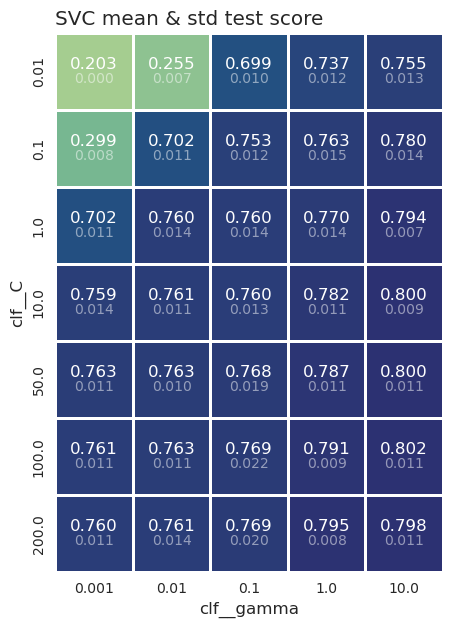

In [19]:
plot_hm_params(svc_gs_results, 'SVC')

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Con la mejor combinación de hiperparámetros encuentrada, entrenad un clasificador `SVM` (con _train_) y representar las fronteras de decisión con los puntos de _test_.
    
Calcular el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusión. Puede utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.
</div>

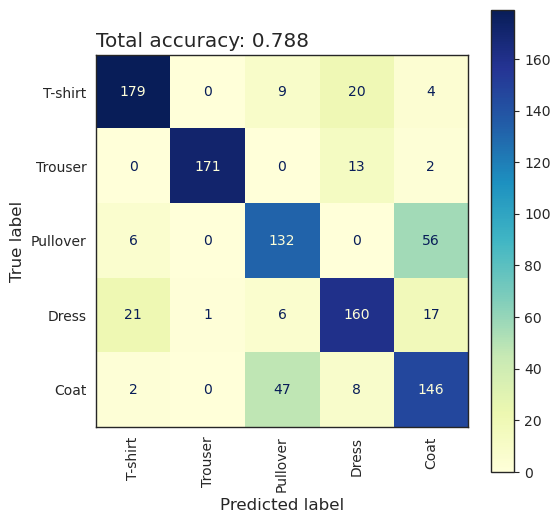

In [20]:
final_svc = gs_svc.best_estimator_.fit(X_train_projection, y_train)
show_cf_accuracy(final_svc, X_test_projection, y_test, labels)

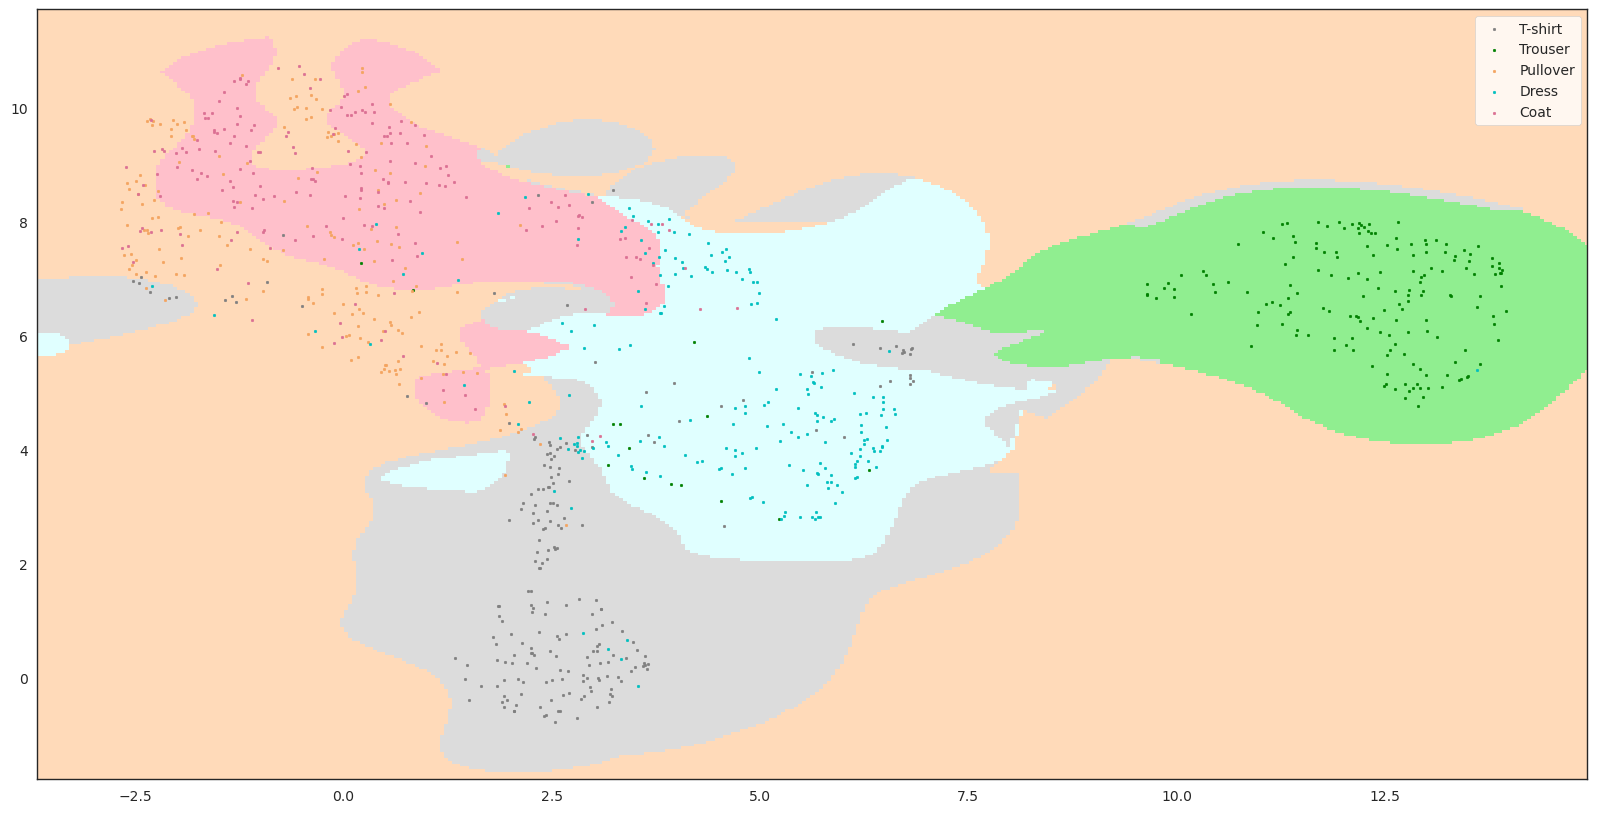

In [21]:
plot_decision_boundaries(final_svc, X_test_projection, y_test)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

Análisis del ejercicio.

   - Comentar los resultados de la búsqueda de los mejores hiperparámetros.
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

### 1.4. Árboles de decisión

Los árboles de decisión son modelos predictivos formados por reglas binarias (si / no) con las que se consigue repartir las observaciones en función de sus atributos y predecir así el valor de la variable respuesta.

Los árboles pueden ser **clasificadores** (para clasificar clases, tales como nuestro ejemplo), o bien **regresores** (para predecir variables continuas).

#### Construcción de un árbol

La creación de las ramificaciones de los árboles se logra mediante el algoritmo de *recursive binary splitting*. Este algoritmo consta de tres pasos principales:

   - El proceso se inicia en lo alto del árbol, donde todas las observaciones pertenecen a la misma región.
   - Se identifican todos los posibles puntos de corte para cada uno de los predictores. Los puntos de corte son cada uno de sus niveles.
   - se evalúan las posibles divisiones de cada predictor de acuerdo a una determinada medida. En el caso de los clasificadores se utilizan: *classification error rate*, Gini, entropía, chi-square.

#### Evitando el *overfitting*

El proceso de construcción de árboles descrito tiende a reducir rápidamente el error de entrenamiento, por lo que generalmente el modelo se ajusta muy bien a las observaciones utilizadas como entrenamiento (conjunto de *train*). Como consecuencia, los árboles de decisión tienden al *overfitting*. 

Para prevenirlo, utilizaremos dos hiperparámetros:

   - `max_depth`: la profundidad máxima del árbol. Exploraremos los valores entre 4 y 10.
   - `min_samples_split`: el número mínimo de observaciones que debe tener una hoja del árbol para poder dividir. Exploraremos los valores: 2, 10, 20, 50 y 100.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

Calculad el valor óptimo de los hiperparámetros `max_depth` y `min_samples_split`. Utilizad una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcular su promedio y la desviación estándar. Haced un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.
    
Pódeis utilizar el módulo `GridSearchCV` de `sklearn` el cálculo de los mejores hiperparámetros con el clasificador `DecisionTreeClassifier` (de `tree` de `sklearn`), y `heatmap` de `Seaborn`.
</div>

En este caso no vamos a realizar una estandarización de los datos de entrada, porque con los árboles de decisión en nigún caso es necesario, ya que son inmunes a la diferencia de escala que pueda haber entre ellos.

In [22]:
dtc_gs = {'max_depth': np.arange(4, 10),
          'min_samples_split': [2, 10, 20, 50, 100]}

DTC = DecisionTreeClassifier()

gs_dtc = GridSearchCV(DTC, param_grid=dtc_gs, cv=4, n_jobs=-1)
gs_dtc.fit(X_train_projection, y_train)
dtc_gs_results = pd.DataFrame(gs_dtc.cv_results_)

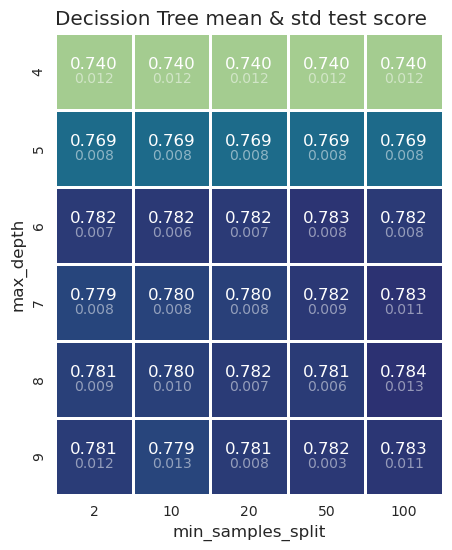

In [23]:
plot_hm_params(dtc_gs_results, 'Decission Tree')

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Con la mejor combinación de hiperparámetros encontrados, entrenad un clasificador `DecisionTreeClassifier` (con `train`) y representar las fronteras de decisión con los puntos de `test`.
    
Calcular el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusión. Puede utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.
</div>

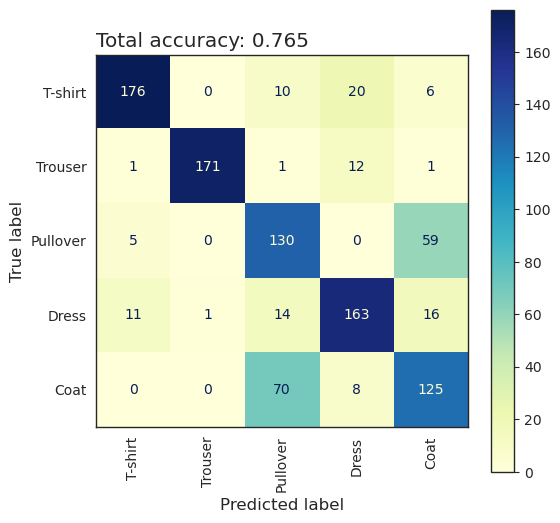

In [24]:
final_dtc = gs_dtc.best_estimator_.fit(X_train_projection, y_train)
show_cf_accuracy(final_dtc, X_test_projection, y_test, labels)

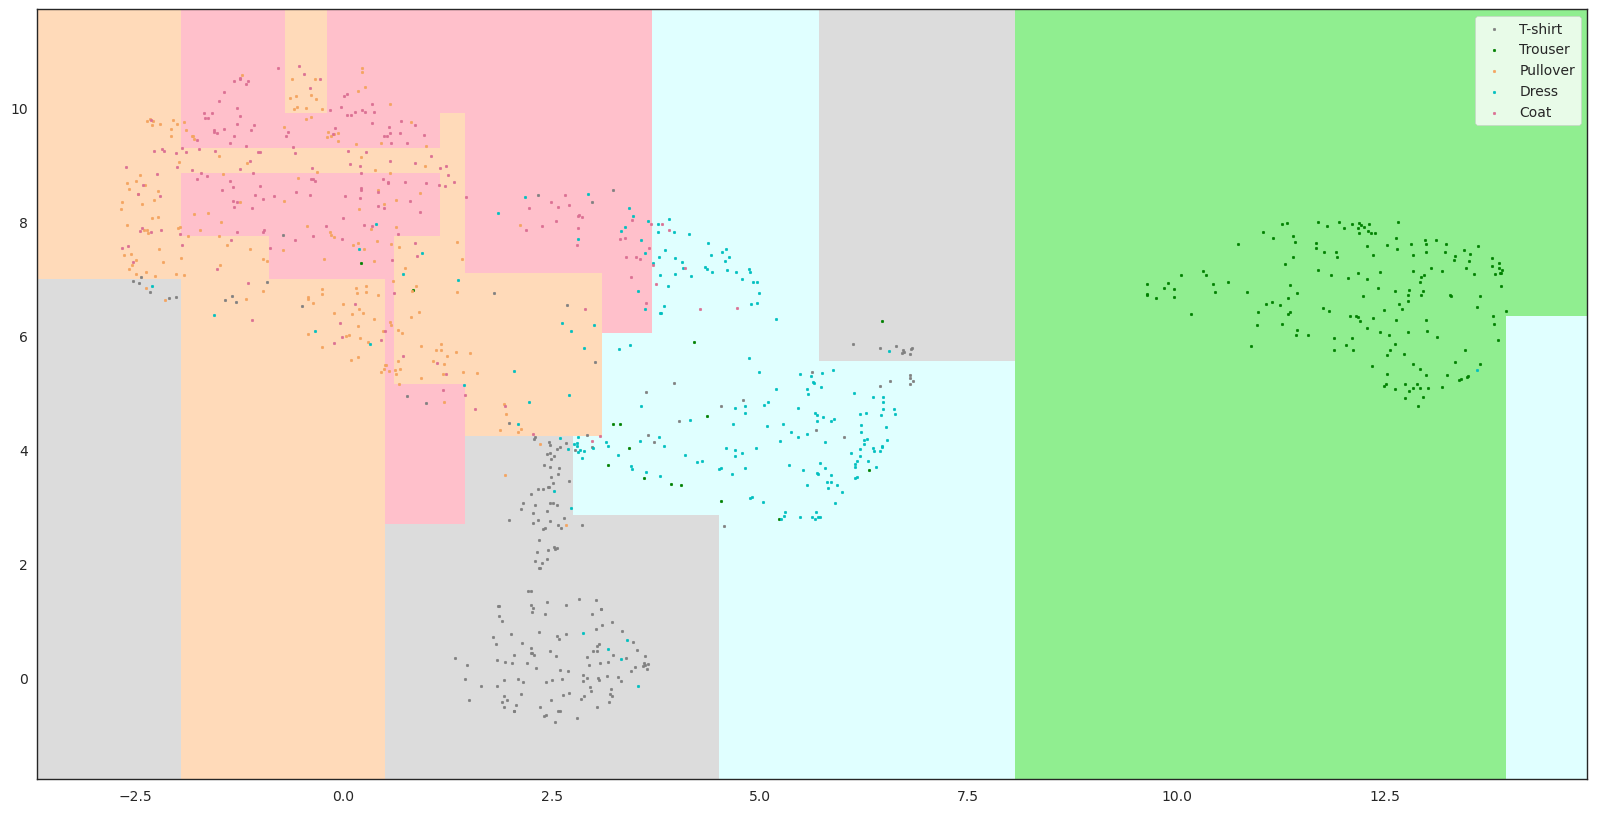

In [25]:
plot_decision_boundaries(final_dtc, X_test_projection, y_test)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

Análisis del ejercicio.

   - Comentar los resultados de la búsqueda de los mejores hiperparámetros.
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

De la búsqueda de hiperparámetros que hemos realizado, podemos concluir que en este caso el *min_sample_split* no tiene un gran efecto sobre la precisión. Por el contrario, el *max_depth*, que fija la profundidad máxima del árbol creado, sí influye de forma muy significativa en la precisión obtenida. Cuando dejamos el árbol con una profundiad máxima muy baja (4), el modelo no es lo suficientemente complejo como para captar las formas de los datos, produciéndose *underfitting*. Es más que probable, por otro lado, que si no restringiésemos nada el árbol, se produciría el efecto contrario de *undefitting*, ya que el modelo aprendería de forma perfecta los datos de entrenamiento, problema habitual en los modelos basados en árbol de decisión.

En este caso las fronteras las vemos todas rectas, porque la clasificación se realiza en forma de condicionales *if/else*, lo que deriva en fronteras de este tipo.

Reentrenando el mejor modelo encontrado con el conjunto de entrenamiento completo obtenemos una precisión de más del 76% que no es la mejor que tenemos hasta el momento, pero se podría decir que es sorprendentemente buena teniendo en cuenta la excesiva sencilled del modelo. Nuevamente los errores cometidos en mayor parte son entre las clases jersey y abrigo.

### 1.5. Mejorando los árboles de decisión

En la práctica, casi nunca se utiliza un solo árbol de decisión, sino que se combinan muchos árboles para obtener mejores resultados. Hay dos maneras de combinar árboles:

  - *__Bagging__*: utilizar el conjunto de entrenamiento original para generar centenar o miles de conjuntos similares utilizando muestreo con reemplazo. El algoritmo _random forest_ está basado en este concepto, la combinación de varios árboles de decisión, cada uno entrenado con una muestra diferente de los datos. La decisión final del clasificador combinado (la _random forest_) se toma por mayoría, dando el mismo peso a todas las decisiones parciales tomadas por los clasificadores base (los árboles).
  
  - *__Boosting__*: se combinan varios clasificadores débiles secuencialmente, y en cada uno de ellos se da más peso a los datos que han sido erróneamente clasificadas en las combinaciones anteriores, para que se concentre así en los casos más difíciles de resolver.
  
Ambos métodos los estudiaremos más en detalle en la próxima PEC, pero en esta haremos un vistazo a los beneficios que nos aporta utilizar combinaciones de árboles respecto un solo árbol.

Al tratarse de árboles, sigue siendo importante optimizar `max_depth` y `min_samples_split`, pero en este caso añadiremos un hiperparámetro más. Para simplificar, de los dos parámetros anteriores optimizaremos sólo `max_depth`:

  - `n_estimators`: número de árboles. Exploraremos los valores: 50, 100 y 200.
  - `max_depth`: la profundidad máxima del árbol. Exploraremos los valores entre 8 y 12.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

Escoged uno de los dos algoritmos mencionados: RandomForestClassifier o GradientBoostingClassifier. Calculad el valor óptimo de los hiperparámetros `n_estimators` y `max_depth`. Utilizad una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcular su promedio y la desviación estándar. Haced un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.
    
Podéis utilizar el módulo `GridSearchCV` de `sklearn` para el cálculo de los mejores hiperparámetros con el clasificador `RandomForestClassifier` o `GradientBoostingClassifier` (de `ensemble` de `sklearn`), y `heatmap` de `Seaborn`.
    
<u>Nota</u>: al utilizar tantos árboles, el _cross validation_ con todas las combinaciones de parámetros es más costosa que en los ejemplos anteriores, y por lo tanto tardará más en ejecutarse.
</div>

In [26]:
rfc_gs = {'max_depth': np.arange(8, 13),
          'n_estimators': [50, 100, 200]}

RFC = RandomForestClassifier()

gs_rfc = GridSearchCV(RFC, param_grid=rfc_gs, cv=4, n_jobs=-1)
gs_rfc.fit(X_train_projection, y_train)
rfc_gs_results = pd.DataFrame(gs_rfc.cv_results_)

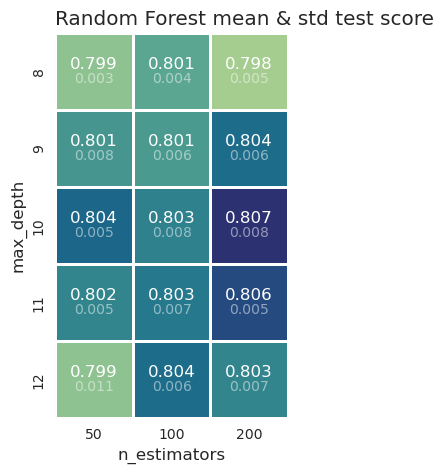

In [27]:
plot_hm_params(rfc_gs_results, 'Random Forest')

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Con la mejor combinación de hiperparámetros encontrada, entrenad un clasificador con el modelo elegido (con _train_) y representar las fronteras de decisión con los puntos de test.
    
Calcular el _accuracy_ del modelo obtenido sobre test y la matriz de confusión. Puede utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.
</div>

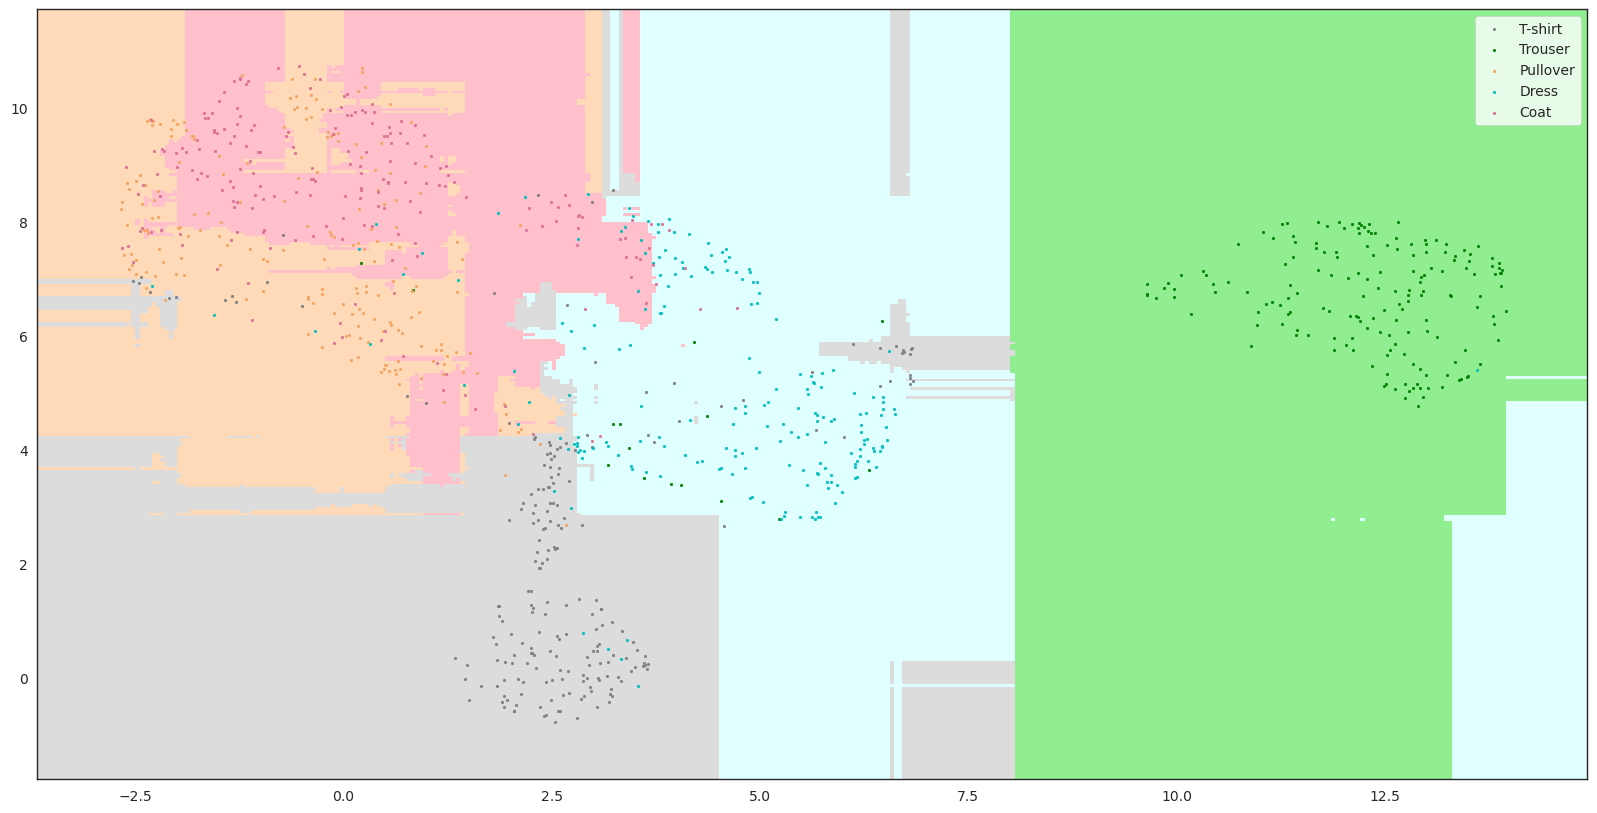

In [28]:
final_rfc = gs_rfc.best_estimator_.fit(X_train_projection, y_train)
plot_decision_boundaries(final_rfc, X_test_projection, y_test)

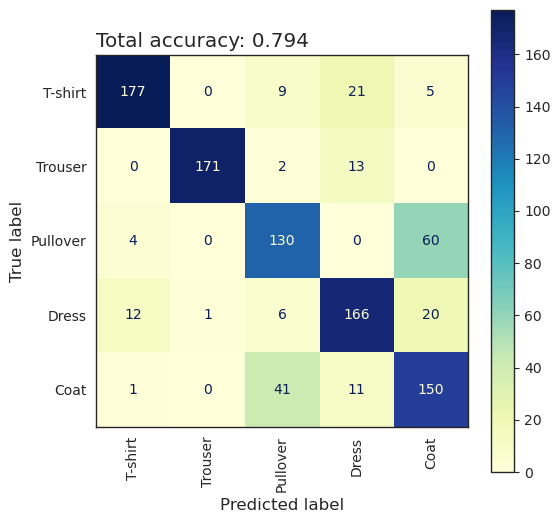

In [29]:
show_cf_accuracy(final_rfc, X_test_projection, y_test, labels)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

Análisis del ejercicio.

   - Comentar los resultados de la búsqueda de los mejores hiperparámetros.
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
   - ¿Ha habido mejora respecto a utilizar un simple árbol de decisión?
</div>

Vemos como el hecho de utilizar un método de *ensamble* como Random Forest mejora los resultados que teníamos con un árbol de decisión simple de forma notable, pasando del 76% de exactitud al 80%. En este caso, los hiperparámetros probados no suponen una gran diferencia en la exactitud obtenida en el modelo. Hay que destacar que Random Forest tiene muchos más hiperparámetros, por lo que es probable que hubiese una combinación de ellos con la que obtiviésemos unos resultados mejores.

Las fronteras de decisión de clases siguen el mismo patrón que con el árbol de decisión (líneas versicales y horizontales), pero en este caso tenemos muchas más fronteras y éstas son más complejas, derivado tanto de la mayor profundidad utilizada ahora, como de estar utilizando muchos árboles en lugar de uno sólo y decidir la clase por votación de la mayoría.

Las predicciones sobre el conjunto de test siguen el mismo patrón, con la mayoría de elementos mal clasificados entre las clases abrigo y jersey, que son las clases cuyos elementos están más mezclados, y cuya separación es por lo tanto más difícil.

Con el mejor set de parámetros de el Random Forest hemos conseguido un 4% más de precisión en el conjunto de test que con el árbol de decisión sencillo, por lo que la mejora al utilizar un método de *ensamble* es notable. Además, con este modelo tenemos los mejores resultados de todos los evaluados, con prácticamente un 80% de precisión, si bien no dista mucho de la que hemos obtenido con los modelos KNN y SVM con sus respectivos mejores hiperparámetros. Hay que destacar que los métodos de *ensamble* son más costosos computacionalmente, por lo que en cada caso habrá que evaluar si la mejora en los resultados compensa el coste computacional, algo que no parece ser el caso en este ejemplo.

<a id='ej2'></a>
# 2. Implementación del caso práctico (5 puntos)

En este caso práctico, construiremos un modelo predictivo que detectará si el comentario escrito por un usuario de Amazon en una reseña sobre una aplicación para Android es bueno o no, utilizando exclusivamente el texto de dicho comentario como punto de partida. El problema que vamos a resolver en este apartado se engloba dentro del área de investigación conocida como [análisis de sentimiento (_sentiment analysis_)](https://es.wikipedia.org/wiki/An%C3%A1lisis_de_sentimiento) que utiliza, entre otras cosas, procesamiento de lenguaje natural, análisis de texto y lingüística computacional para identificar y extraer información subjetiva de distintos recursos.

El conjunto de datos con el que trabajaremos se ha obtenido de las valoraciones y comentarios dejados por un grupo de usuarios en las reseñas de diferentes productos de Amazon. En nuestro caso, nos centraremos en un subconjunto de 10000 reseñas de aplicaciones para Android con valoraciones desde 1 hasta 5 estrellas. El conjunto de datos original lo podéis encontrar en el siguiente enlace: http://jmcauley.ucsd.edu/data/amazon/

## 2.0. Carga de datos

Lo primero que haremos será cargar el dato, que viene dentro de un fichero donde cada línea es una reseña en formato [JSON](https://es.wikipedia.org/wiki/JSON).

In [98]:
N_SAMPLES = 10000

review_list = []
with open("Apps_for_Android_5.json", "rt") as f:
    for i, line in enumerate(f):
        if i >= N_SAMPLES:
            break
        review_list.append(json.loads(line))

len(review_list)

10000

Como podemos ver en la siguiente celda, cada reseña se compone de, entre otras cosas, comentario (`'reviewText'`) y valoración (`'overall'`).

In [99]:
review_list[0]

{'reviewerID': 'A1N4O8VOJZTDVB',
 'asin': 'B004A9SDD8',
 'reviewerName': 'Annette Yancey',
 'helpful': [1, 1],
 'reviewText': "Loves the song, so he really couldn't wait to play this. A little less interesting for him so he doesn't play long, but he is almost 3 and likes to play the older games, but really cute for a younger child.",
 'overall': 3.0,
 'summary': 'Really cute',
 'unixReviewTime': 1383350400,
 'reviewTime': '11 2, 2013'}

## 2.1. Preprocesamiento de los datos

Con el objetivo de aplicar algunos de los algoritmos vistos en el primer apartado de la PEC, procesaremos el conjunto de datos inicial para poder obtener desde el texto del comentario una serie de atributos descriptivos numéricos lo suficientemente representativos como para que al construir sobre ellos un clasificador obtengamos los resultados esperados.

El procesamiento del texto realizará los siguientes pasos:
- El texto se pasará por completo a letras minúsculas, minimizando la variedad de palabras resultante.
- Los números, direcciones de páginas web y de correo y el símbolo del dólar se substituirán por palabras especiales.
- Separación del texto en las palabras que posteriormente darán lugar a los futuros tokens.
- Eliminación de los caracteres no alfanuméricos que puedan quedar.
- Eliminación de [palabras vacías (_stopwords_)](https://es.wikipedia.org/wiki/Palabra_vac%C3%ADa) que no aportan información, tales como artículos o preoposiciones.
- Simplificación de las palabras quedándonos sólo con el lexema (raíz) de la misma, unificando en un solo token distintas palabras relacionadas semánticamente.

La siguiente funcion toma una reseña y devuelve una dupla formada por los tokens resultantes del procesado y si la valoración es buena o no, es decir, si su valoración es mayor que 3 o no.

In [100]:
def process_review(review):
    text = review['reviewText']
    # Pasamos el texto a minúsculas para minimizar la variedad de palabras.
    text = text.lower()
    # Reemplazamos los números por el token 'number'.
    text = re.sub('[0-9]+', 'number', text)
    # Cualquier cosa que comience con http o https:// es reemplazado por 'httpaddr'.
    text = re.sub('(http|https)://[^\s]*', 'httpaddr', text)
    # Cadenas de texto con "@" en su interior son consideradas direcciones de email: 'emailaddr'.
    text = re.sub('[^\s]+@[^\s]+', 'emailaddr', text)
    # El signo '$' es reemplazado por el token 'dollar'.
    text = re.sub('[$]+', 'dollar', text)
    # Separamos el comentario en palabras individuales o tokens.
    words = re.split('[ \@\$\/\#\.\-\:\&\*\+\=\[\]\?\!\(\)\{\}\,\'\"\>\_\<\;\%]', text)
    
    # Usaremos PorterStemmer para extraer las raíces de las palabras.
    stemmer = nltk.stem.porter.PorterStemmer()
    # Carreguem les "stopwords" angleses en un set perquè aquest és més eficient que una llista.
    stopwords = set(stopword.lower() for stopword in nltk.corpus.stopwords.words('english'))
    # 
    tokens = []
    for word in words:
        # Eliminamos todo aquello que no sean caracteres alfanuméricos.
        token = re.sub('[^a-zA-Z0-9]', '', word)
        # Tomamos únicamente sólo quellos los tokens que no estén vacíos ni pertenezcan al conjunto "stopwords"
        if token and word not in stopwords:
            # Extraemos la raíz de cada palabra.
            token = stemmer.stem(token)
            # Añadimos el token a la lista.
            tokens.append(token)
        
    # Devolvemos el token y si la reseña es buena o no (buena si la puntuación es mayor que 3).
    return tokens, review['overall'] > 3

In [101]:
process_review(review_list[0])

(['love',
  'song',
  'realli',
  'wait',
  'play',
  'littl',
  'less',
  'interest',
  'play',
  'long',
  'almost',
  'number',
  'like',
  'play',
  'older',
  'game',
  'realli',
  'cute',
  'younger',
  'child'],
 False)

Con ayuda de la función definida previamente, procesamos todas las reseñas:

In [102]:
tokens_list = []
y_list = []
for review in review_list:
    tokens, is_good = process_review(review)
    tokens_list.append(tokens)
    y_list.append(1 if is_good else 0)

In [103]:
tokens_list[0], y_list[0]

(['love',
  'song',
  'realli',
  'wait',
  'play',
  'littl',
  'less',
  'interest',
  'play',
  'long',
  'almost',
  'number',
  'like',
  'play',
  'older',
  'game',
  'realli',
  'cute',
  'younger',
  'child'],
 0)

In [104]:
y = np.array(y_list)

En este punto, para cada reseña tenemos un valor binario que nos indica si es buena o no (variable objetivo) y una lista de tokens que puede o no tener elementos en común con las las listas de tokens de otras reseñas. Estas listas de tokens, tal y como están, aún no nos sirven a modo de atributos descriptivos para poder entrenar un modelo como los que hemos visto previamente.

Con el propósito de crear un número de variables igual y con el mismo significado para todas y cada una de las muestras, nos decidimos a elegir los tokens comunes en al menos el 1% de los comentarios para, posteriormente, realizar un conteo de veces que aparece cada uno de dichos tokens en cada reseña y generar, para cada reseña, un vector de variables numéricas en la que cada posición hace referencia a cada uno de esos tokens relevantes o comunes e indica cuántas veces aparece diccho token en el comentario en cuestión. A esta técnica se la conoce como bolsa de palabras (_bag of words_).

Sin embargo, antes de realizar este proceso, debemos dividir el conjunto de datos en los subconjuntos de entrenamiento y de test, ya que las palabras comunes las debemos decidir teniendo en cuenta sólo los datos de entrenamiento, puesto que cuando tengamos nuestro algoritmo en producción nos encontraremos con reseñas que no habremos tenido en cuenta para generar la mencionada lista de tokens comunes y debemos de estar preparados para ello simulándolo con el subconjunto de test.

Como última aclaración, es imporante, antes de dividir el dataset, conocer cómo es la distribución de las clases dentro del mismo, ya que si esta distribución no está equilibrada es necesario estratificar la división.

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

Estudia la distribución de valoraciones y de la clase (variable objetivo) "_es buena o no_".
    
</div>

La distribucuón de las valoraciones originales es la siguiente:

10000


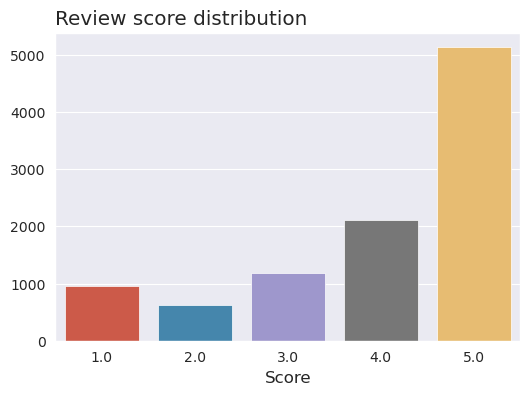

In [105]:
sns.set_style('darkgrid')

val = np.array([review['overall'] for review in review_list])
print(len(val))
unique, counts = np.unique(val, return_counts=True)
ax = sns.barplot(x=unique, y=counts, errorbar=None)
ax.set_title('Review score distribution')
ax.set_xlabel('Score')
plt.show()

Una vez binarizada dicha variable, la distribución de la clase objetivo (buena/mala) es la siguiente:

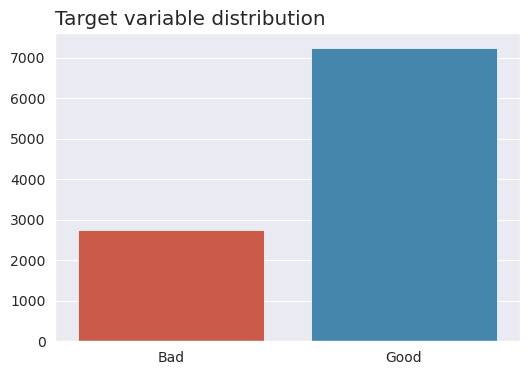

In [95]:
unique, counts = np.unique(y, return_counts=True)

ax = sns.barplot(x=unique, y=counts, errorbar=None)
ax.set_title('Target variable distribution')
ax.set_xticklabels(['Bad', 'Good'])
plt.show()

Vemos como no tenemos una variable objetivo balanceada, sino que tenemos muchas más reseñas buenas que malas. Por lo tanto, necesitaremos hacer un muestreo estratificado.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Dividid el _dataset_ en dos subconjuntos, __*train*__ (80% de los datos) y __*test*__ (20% de los datos). Nombrad los conjuntos como: tokens_list_train, tokens_list_test, y_train, y_test. Utilizad la opción `random_state = 24`.
    
Podéis utilizar la implementación `train_test_split` de `sklearn`.

<u>Nota:</u> utilizad el parámetro `stratify` en caso de que sea necesario.
    
</div>

In [38]:
tokens_list_train, tokens_list_test, y_train, y_test = train_test_split(tokens_list, y, test_size=0.2, random_state=24, stratify=y)

Es el momento de elegir una lista de los tokens representativos del conjunto de muestras de entrenamiento. Llamaremos a esta lista vocabulary.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Guarda en la variable __*vocabulary*__ la lista de tokens que aparecen al menos en un 1% de las reseñas de entrenamiento.
    
</div>

In [39]:
n_train = len(tokens_list_train)
print(f'Samples in training set: {n_train}')
ncount_min = n_train*0.01

Samples in training set: 8000


Realizamos un conteo de las palabras en cada review, pero contamos sólamente una vez cada palabra, independientemente de cuántas veces aparezca en el texto. 

In [40]:
# We create a list of present words, counting just once each word appearing in a review.
unique_words = [word for tokens in tokens_list_train for word in set(tokens)]

# We create a vocabulary with all the words that appear at least 1% of the time (ncount_min times).
vocabulary = [word for word, count in Counter(unique_words).items() if count >= ncount_min]

# Sort the list alphabetically
vocabulary.sort()

print(f'Number of words in vocabulary: {len(vocabulary)}')
print(f'First words: {vocabulary[:10]}')

Number of words in vocabulary: 404
First words: ['abil', 'abl', 'absolut', 'access', 'account', 'actual', 'ad', 'add', 'addict', 'ago']


Con la lista de tokens obtenida crearemos un diccionario para poder traducir cada uno de ellos a un identificador numérico: la posición que ocupará la palabra dentro del vector resultante.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Crea en la variable <i><strong>vocabulary_dictionary</strong></i> el diccionario formado por los tokens (claves) y su posición dentro de la lista __*vocabulary*__.
    
</div>

In [41]:
vocabulary_dictionary = {vocabulary : i for i, vocabulary in enumerate(vocabulary)}

print(f'First words in vocabulaty dictionary: \n{list(vocabulary_dictionary.items())[:10]}')

First words in vocabulaty dictionary: 
[('abil', 0), ('abl', 1), ('absolut', 2), ('access', 3), ('account', 4), ('actual', 5), ('ad', 6), ('add', 7), ('addict', 8), ('ago', 9)]


Finalmente, con la ayuda del diccionario que acabamos de crear, transformaremos todos los comentarios de las reseñas, tanto de entrenamiento como de test, en vectores numéricos del mismo tamaño donde cada posición hará referencia a cada uno de los tokens de la lista __*vocabulary*__ guardando el número de veces que aparece dicho token en la muestra.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Crea las variables <i><strong>X_train</strong></i> y <i><strong>X_test</strong></i> transformando las variables <i><strong>tokens_list_train</strong></i> y <i><strong>tokens_list_test</strong></i> con ayuda del diccionario <i><strong>vocabulary_dictionary</strong></i>.

<u>Nota:</u> la clase `Counter` del módulo `collections` te será muy útil para este cometido.

</div>

In [42]:
def tokenize(tokens_list, voc_dict):
    X = []
    for rewiew in tokens_list:
        token_num_list = [voc_dict[token] for token in rewiew if token in voc_dict]
        counter = [Counter(token_num_list).get(word, 0) for word in voc_dict.values()]
        X.append(counter)
    return X

In [43]:
X_train = tokenize(tokens_list_train, vocabulary_dictionary)
X_test = tokenize(tokens_list_test, vocabulary_dictionary)

Vemos un ejemplo de como queda la primera reseña:

In [44]:
print(f'Length of features: {len(X_train[0])}')

Length of features: 404


## 2.2. Análisis descriptivo

Una vez que tenemos los atributos descriptivos y la variable objetivo debidamente procesados, es el momento de analizar cómo es el dato con el que trabajaremos hasta el final de la PEC.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Con anterioridad hemos analizado la distribución de la variable objetivo, ahora es el momento de analizar el resto de variables.

Analiza la distribución de los tokens `uninstal`, `love`, `great`, `wast`, `delet`, `bore` por medio de histogramas, uno para cada atributo.
</div>

Para trabajar con los datos de forma más cómoda, transformamos los datos en un DataFrame.

In [45]:
X_train = pd.DataFrame(X_train, dtype=np.int8, columns=vocabulary_dictionary.keys())
X_test = pd.DataFrame(X_test, dtype=np.int8, columns=vocabulary_dictionary.keys())
X_train.head()

,abil,abl,absolut,access,account,actual,ad,add,addict,ago,...,without,wonder,word,work,world,worth,would,wrong,year,yet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


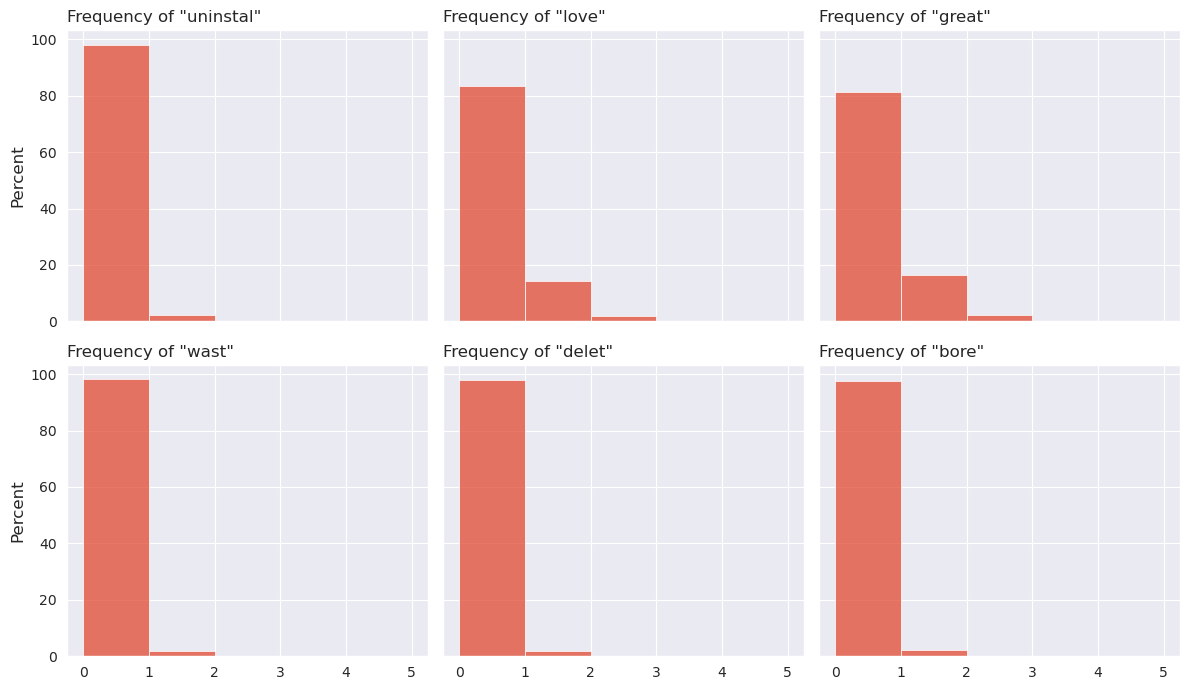

In [46]:
tk_list = ['uninstal', 'love', 'great', 'wast', 'delet', 'bore']


fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharey=True, sharex=True)

for tk, ax in zip(tk_list, axes.flatten()):
    sns.histplot(data=X_train, x=tk, binwidth=1, stat='percent', ax=ax)
    ax.set_title(f'Frequency of "{tk}"', fontsize=12)
    ax.set_xlabel('')

fig.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

¿Que distribución presentan los datos?, ¿a qué crees que es debido?
</div>

Todas las palabras tienen una distribución similar, donde la mayoría de los valores son iguales a 0. Tiene sentido, si pensamos que es el número de veces que aparece una palabra o término en una review. Una palabra en específico no aparecerá mas que en un porcentaje pequeño de las reseñas, y por lo tanto en la mayoría de reseñas la mayor frecuencia de aparición de una palabra será cero. Además, cuando esta aparece, en la mayoría de los casos lo hace una sola vez. Teniendo en cuenta que las reseñas tienden a ser cortas, parece lo más razonable pensar que las palabras aparezcan, en su mayoría, una sola vez en el texto. Sólo palabras más genéricas como "great" o "love" si que vemos que aparecen más veces repetidas en una misma review. Por otro lado, vemos que estas dos últimas son las palabras que más aparecen de las 6 analizadas, que lo hacen en aproximadamente el 20% de las reviews.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Repite los histogramas separando por colores la variable objetivo (dentro del mismo gráfico, diferenciar entre si la reseña es buena o no).
    
<u>Nota</u>: puedes utilizar el parámetro `alpha` para que se vean los dos gráficos a la vez.
</div>

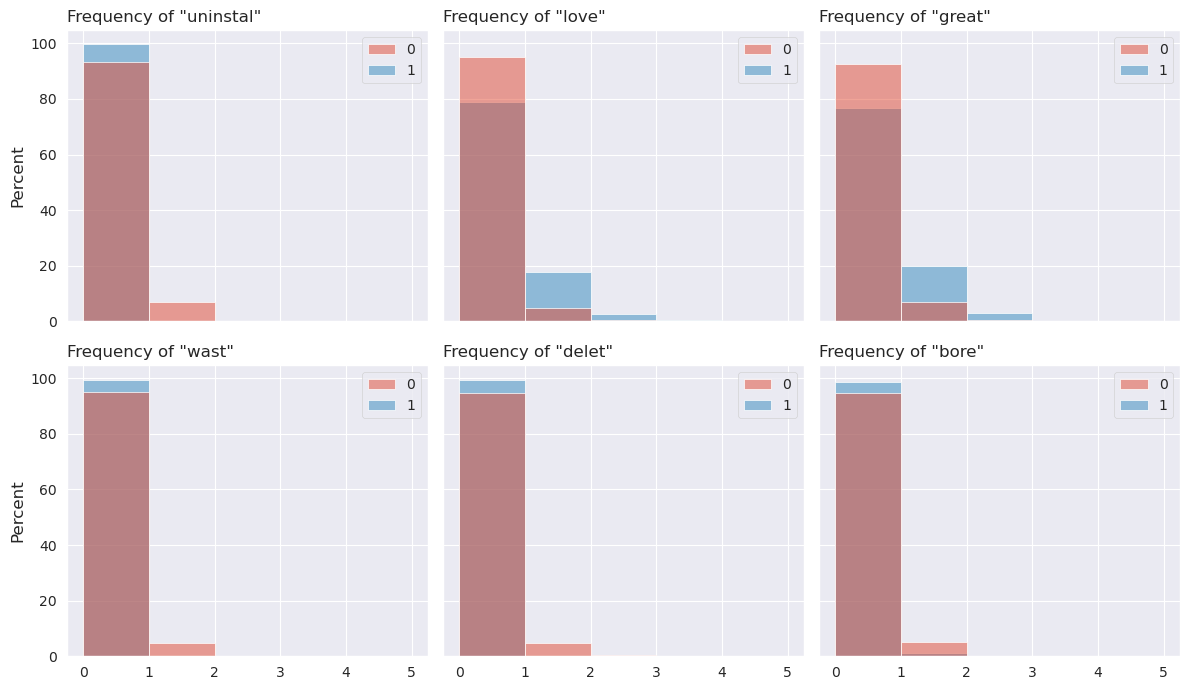

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharey=True, sharex=True)

for tk, ax in zip(tk_list, axes.flatten()):
    sns.histplot(data=X_train, x=tk, binwidth=1, hue=y_train, alpha=0.5, stat='percent', common_norm=False, ax=ax)
    ax.set_title(f'Frequency of "{tk}"', fontsize=12)
    ax.set_xlabel('')

fig.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

¿Qué conclusiones puedes sacar de estas últimas gráficas?
</div>

Se puede observar como palabras con connotación positiva como *love* o *great* es mucho más probable que aparezcan (incluso de forma repetida) en la categoría de reseña positiva (1) que en la negativa (0), como era de esperar. Lo contrario también ocurre, ya que palabras como con connotación negativa, como *wast*, *bore*, *delet* o *uninstal* aparecen casi en exclusiva en reseñas negativas.

La aparición de estas palabras en un texto, por lo tanto, parece ser un indication bastante claro de si una reseña es positiva o negativa, y parece razonable que podamos enrutar la clasificación de una reseña a partir de la frecuencia de aparición de estas palabras.

## 2.3. Entrenamiento del modelo

En este subapartado construiremos varios modelos con las ténicas vistas previamente y estudiaremos su comportamiento.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Construye un árbol de decisión de profundidad 3 con las muestras del conjunto de entrenamiento.

Evalúa la capacidad predictiva del modelo con las métricas de `accuracy` y `roc_auc`, tanto en el subconjunto de entrenamiento como en el de test.
</div>

Tal como se nos plantea el enunciado, vamos a utilizar todo el conjunto de datos de entrenamiento para entrenar los modelos, y posteriormente los evaluaremos en el conjunto de test. En un caso real en el que quisiésemos tomar una decisión sobre el modelo (o hiperparámetros del modelo) a usar, dejaríamos el conjunto de test para evaluar el modelo final, una vez tomada la decisión sobre cual utilizar. La evaluación de cada uno de los modelos, la realizarímos bien apartando otro conjunto para utilizarlo como conjunto de evaluación o, mejor, mediante cross-validation, tal y como hemos hecho en el ejercicio anterior. De esta forma, evitaríamos el *overfitting* que se pueda producir en la elección del modelo, seleccionando aquel que se comporte mejor específicamente sobre el conjunto de test que hemos apartado.

In [48]:
def calc_metrics(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    metrics = dict()
    for X, y, label in zip([X_train, X_test], [y_train, y_test], ['train', 'test']):
        metrics[label] = dict()
        metrics[label]['accuracy'] = accuracy_score(y, clf.predict(X))
        metrics[label]['roc_auc'] = roc_auc_score(y, clf.predict_proba(X)[:,1])
    return pd.DataFrame(metrics)


DTC = DecisionTreeClassifier(max_depth=3)
dt_results = calc_metrics(DTC, X_train, y_train, X_test, y_test)
dt_results

,train,test
accuracy,0.742375,0.740500
roc_auc,0.660959,0.678892


Podemos ver como tanto el accuracy como el ROC AUC son prácticamente iguales en los conjuntos de test y de entrenamiento, lo cual nos puede dar un indicativo de que el modelo que estamos utilizando es demasiado simple para capturar la tendencia de los datos, y por lo tanto estamos en una situación de *underfitting*. Esto tiene sentido si tenemos en cuenta que tenemos un árbol de decisión que hemos limitado a una profundidad de sólo 3, con un conjunto de *features* de más de 400, por lo que sólo podremos estar teniendo en cuenta unas pocas de ellas. El valor de *accuracy* es de 0.74, que no parece un valor muy malo, pero vemos como el ROC AUC es de sólo 0.67, un valor bastante pobre si tenemos en cuanta que el valor mínimo para esta métrica utilizando un clasificador aleatorio es de 0.5.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Comprueba qué atributos son los más importantes del árbol mostrando sus nodos y los pares variable-valor que utiliza cada uno de ellos para dividir y subdividir los datos. Es importante que en los nodos del árbol aparezca a qué token hace referencia.

<u>Nota:</u> el siguiente enlace muestra una forma elegante de visualizar los nodos de los árboles: https://mljar.com/blog/visualize-decision-tree/.
</div>

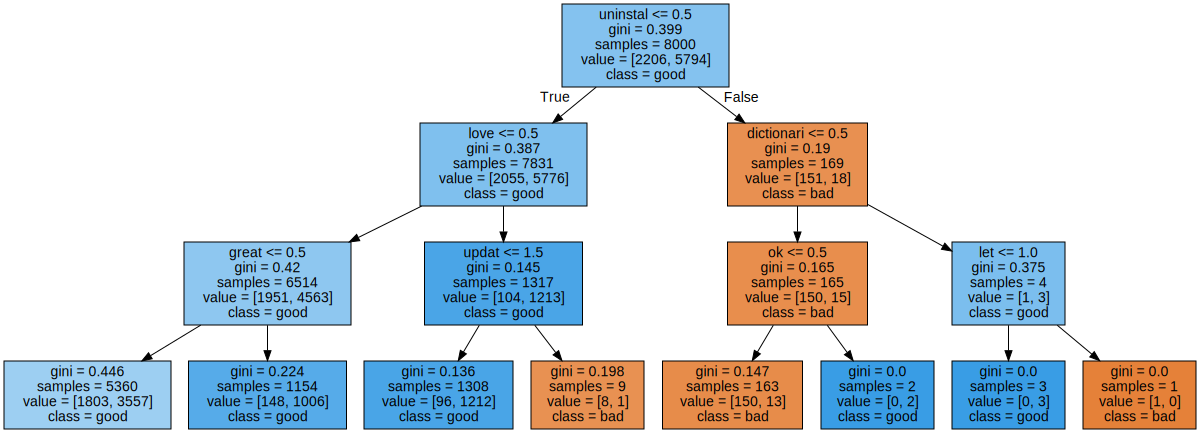

In [49]:
dot_data = tree.export_graphviz(DTC,
                     out_file=None,
                     feature_names = X_train.columns,
                     class_names=['bad', 'good'],
                     filled = True)

graph = graphviz.Source(dot_data, format="png")
graph

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

Según el árbol de decisión, ¿qué tokens son los más importantes a la hora de discriminar si un comentario es bueno o no?
</div>

El árbol de decisión divide el conjunto de datos atendiendo a un criterio de ganancia de información, y por lo tanto las divisiones primeras que se realicen serán las que más ganancia de información proporcionan. Podemos ver como la primera palabra que se usa para dividir es *uninstal*, que dividirá el conjunto original en dos según dicha palabra aparezca (unistal > 0.5) o no (uninstal <=0.5); el primero de los conjuntos será etiquetado por mayoría en como "mala review" y el segundo como "buena review". Estos dos grupos se dividen nuevamente en dos cada uno de ellos por las palabras *love* y *dictionari* respectivamente, dando lugar a 4 grupos en el tercer nivel del árbol. Se vuelve a hacer una nueva división para acabar con 8 grupos utilizando las palabras *great*, *updat*, *ok* y *go*, momento en el cual se finaliza el algoritmo porque se ha llegado al criterio de parada con una profundidad máxima de 3. Podemos ver además que sólo unas pocas palabras de las más de 400 presentes como variables dependientes las estamos utilizando para generar el modelo, y por lo tanto tenemos un modelo muy sencillo.

Otra buena forma de analizar qué atributos descriptivos son los más interesantes para discriminar a qué clase pertenece cada muestra es construir un _random forest_ para estudiar la _feature importance_ de los atributos descriptivos.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Calcula el valor óptimo de los hiperparámetros `max_depth` y `n_estimators` para un `RandomForestClassifier`. Utiliza una búsqueda de rejilla con la métrica `roc_auc` y con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcula su promedio y la desviación estándar de dicha métrica.
    
Puedes utilizar el módulo `GridSearchCV` de `sklearn` para obtener la mejor combinación de hiperparámetros.
</div>

In [50]:
RF = RandomForestClassifier(n_estimators=100, max_depth=3)
rf_gs_params = {'max_depth': range(3, 13),
                'n_estimators': [50, 100, 200, 400, 800]}

rf_gs = GridSearchCV(RF, rf_gs_params, cv=4, scoring='roc_auc', n_jobs=-1)
rf_gs.fit(X_train, y_train)
rfc_gs_results = pd.DataFrame(rf_gs.cv_results_).sort_values(by='rank_test_score')

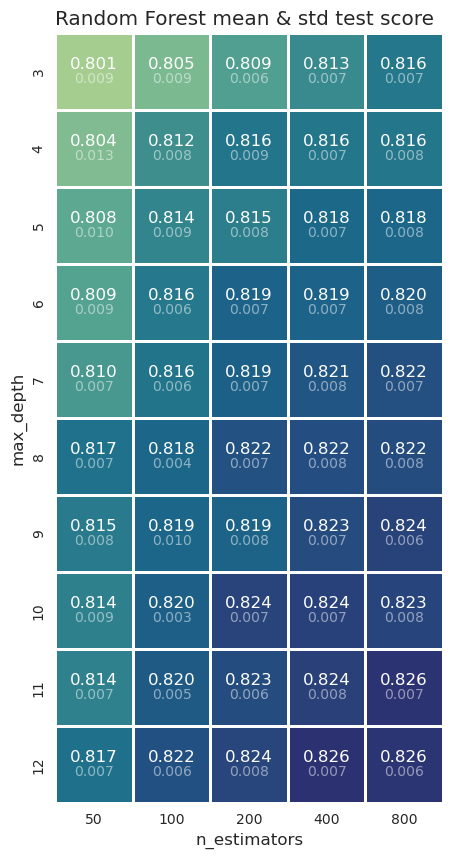

In [51]:
plot_hm_params(rfc_gs_results, 'Random Forest')

In [52]:
print(f'Best paramers: {rf_gs.best_params_}')

Best paramers: {'max_depth': 12, 'n_estimators': 400}


<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Con la mejor configuración de hiperparámetros encontrada, construye un modelo de clasificación con _random forest_.

Evalúa la capacidad predictiva del modelo con las métricas de `accuracy` y `roc_auc`, tanto en el subconjunto de entrenamiento como en el de test.
</div>

In [53]:
rf_results = calc_metrics(rf_gs.best_estimator_, X_train, y_train, X_test, y_test)
rf_results

,train,test
accuracy,0.784625,0.768500
roc_auc,0.912139,0.844421


<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Con el modelo de _random forest_ construido, muestra cuáles son los tokens más importantes para discriminar a qué clase pertenece cada muestra según el modelo.

<u>Nota:</u> utiliza el atributo `feature_importances_` del modelo de _random forest_ creado.
</div>

In [54]:
feat_imp = pd.DataFrame({'Importance': rf_gs.best_estimator_.feature_importances_}, 
                        index=rf_gs.best_estimator_.feature_names_in_
                        ).sort_values('Importance', ascending=False)
feat_imp.head(10)

,Importance
uninstal,0.073797
love,0.070947
great,0.056306
wast,0.044258
delet,0.042759
bore,0.024541
easi,0.018304
ok,0.018174
best,0.017636
remov,0.015735


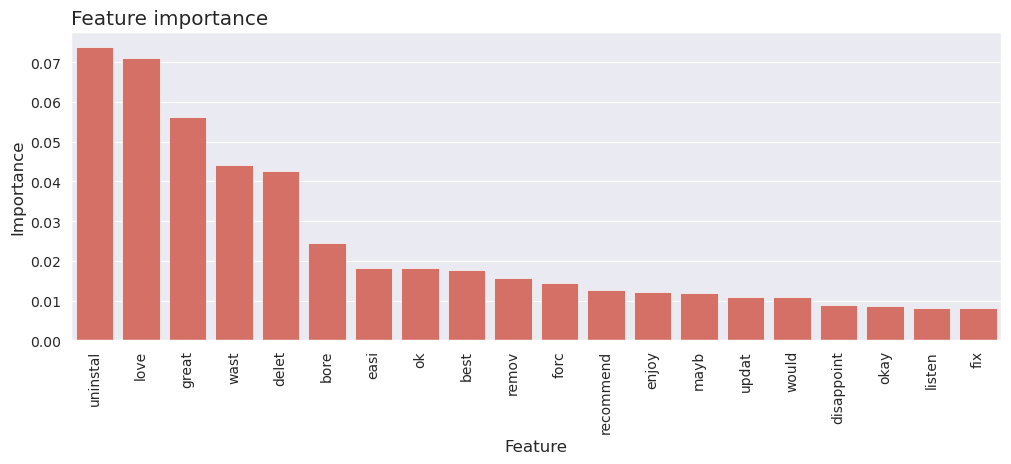

In [55]:
fig, ax = plt.subplots(figsize=(12,4))
top20 = feat_imp.head(20)
sns.barplot(x=top20.index, y='Importance', data=top20, color='#e66153', ax=ax)
ax.set_xticklabels(top20.index, rotation=90)
ax.set_title('Feature importance')
ax.set_xlabel('Feature')
plt.show()

En la gráfica mostramos las 20 palabras más importantes en la clasificación con Random Forest, y podemos ver como las palabras que más importancia tienen son *uninstal*, *love*, *great*, *wast* y *delet*, muy similares a las que habíamos determinado con el árbol de decisión.

Tradicionalmente, modelos probabilísticos como el de Naïve-Bayes han demostrado ser bastante efectivos con problemas similares.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Construye un modelo con `GaussianNB`.

Evalúa la capacidad predictiva del modelo con las métricas de `accuracy` y `roc_auc`, tanto en el subconjunto de entrenamiento como en el de test.
</div>

In [56]:
NB = GaussianNB()

nb_results = calc_metrics(NB, X_train, y_train, X_test, y_test)
nb_results

,train,test
accuracy,0.760500,0.744000
roc_auc,0.801403,0.776171


Finalmente, comprobaremos qué tal se comporta un clasificador lineal en nuestro problema.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Construye un modelo con `SVC` con `kernel` lineal.

Evalúa la capacidad predictiva del modelo con las métricas de `accuracy` y `roc_auc`, tanto en el subconjunto de entrenamiento como en el de test.
</div>

In [57]:
SVC_clf = SVC(kernel='linear', probability=True)

svc_results = calc_metrics(SVC_clf, X_train, y_train, X_test, y_test)
svc_results

,train,test
accuracy,0.837500,0.806000
roc_auc,0.881075,0.842887


<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

Comenta los resultados obtenidos.
</div>

El modelo de Naïve-Bayes ha obtenido un resultado algo peor que el de Random Forest, con una precisión del 0.74 y una AUC del 0.77. Sin embargo, este método tiene a su favor el menor tiempo de entrenamiento, que es más bajo de todos.

El modelo de SVM con kernel lineal ha obtenido un resultado mejor que el RandomForest y Naïve-Bayes, ya que tenemos una ROC AUC similar de 0.84, pero una exactitud considerablemente mejor, superando el 80%, mientras que nos quedábamos en el 76% con el Random Forest. Además, hay que tener en cuenta que no hemos optimizado hiperparámetros, por lo que es posible que con una optimización de éstos se pudiese mejorar el resultado. La mejora obtenida, eso si, no viene sin coste, pues computacionalmente es el modelo más costoso de los tres, ya que como tenemos un gran espacio dimensional, el tiempo de entrenamiento sufre de la llamada *maldición de la dimensionalidad*, que no sufrimos de forma tan notable con los otros modelos.

## 2.4. Predicción de nuevos casos

En este caso vamos a comprobar cómo se comporta el mejor de nuestros clasificadores con dos reseñas completamente nuevas.

In [58]:
new_reviews = [
    {
        'reviewText': "The best application ever!!!",
        'overall': 5.0,
    },
    {
        'reviewText': "The worst application ever :'(",
        'overall': 1.0,
    },
]

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Con el mejor de los modelos creados, predice si estas dos nuevas reseñas son buenas o no.
</div>

In [59]:
tokens_list = []
y_list = []
for review in new_reviews:
    tokens, is_good = process_review(review)
    tokens_list.append(tokens)
    y_list.append(1 if is_good else 0)
    
X_new = tokenize(tokens_list, vocabulary_dictionary)
X_new = pd.DataFrame(X_new, dtype=np.int8, columns=vocabulary_dictionary.keys())

In [60]:
y_list

[1, 0]

Utilizamos el clasificador lineal, pues como hemos comentado es el que nos ha dado mejores resultados, a pesar de su mayor coste computacional.

In [61]:
SVC_clf.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [62]:
SVC_clf.predict(X_new)

array([1, 1])

Vemos como a pesar de contar con un clasificador bastante bueno, no hemos conseguido clasificar las dos nuevas reseñas correctamente, y sólo la reseña buena ha sido clasificada correctamente, mientras que la mala ha sido clasificada también como buena. 

Probamos nuevamente con una review "más negativa", para ver si el modelo es capaz de clasificarla correctamente.

In [63]:
new_reviews = [
    {
        'reviewText': "The best application ever!!!",
        'overall': 5.0,
    },
    {
        'reviewText': "The worst application ever. I'm going to uninstall it, garbage:'(",
        'overall': 1.0,
    },
]

tokens_list = []
y_list = []
for review in new_reviews:
    tokens, is_good = process_review(review)
    tokens_list.append(tokens)
    y_list.append(1 if is_good else 0)
    
X_new = tokenize(tokens_list, vocabulary_dictionary)
X_new = pd.DataFrame(X_new, dtype=np.int8, columns=vocabulary_dictionary.keys())

SVC_clf.predict(X_new)

array([1, 0])

Vemos como en este caso sí que clasifica las dos reviews de forma correcta.

## 2.5. BONUS

Comprueba si las deducciones obtenidas para las reseñas de aplicaciones de Android tienen sentido en otro tipo de productos.

Descárgate las reseñas de otro tipo de producto y compruébalo.

Es de esperar que el modelo entrenado sólo sea válido para el tipo de reseñas que se han utilizado para entrenarlo, por lo que lo esperable es que no funcione correctamente con otro tipo de reseñas. El conjunto de entramiento de datos que se utiliza tiene que ser representativo del conjunto de datos que se quiere utilizar en la predicción, y de no serlo la capacidad predictiva del modelo se verá mermada.

En este caso, por ejemplo, tenemos como palabras con gran "importancia clasificadora" muy específicas del mundo de las aplicaciones, como *unistal*, *delet* o *updat*, que no tienen sentido en reseñas de otro tipo de productos.

Realizaremos la prueba con las reseñas de la categoría "Automotive" de Amazon, que es un tipo de producto muy diferente al de las aplicaciones que hemos utilizado en el ejemplo. Utilizaremos 1000 reseñas de dicho dataset para testear el modelo.

In [64]:
N_SAMPLES = 1000

review_list = []
with open("Automotive_5.json", "rt") as f:
    for i, line in enumerate(f):
        if i >= N_SAMPLES:
            break
        review_list.append(json.loads(line))

tokens_list = []
y_list = []
for review in review_list:
    tokens, is_good = process_review(review)
    tokens_list.append(tokens)
    y_list.append(1 if is_good else 0)
    
X_auto = tokenize(tokens_list, vocabulary_dictionary)
X_auto = pd.DataFrame(X_auto, dtype=np.int8, columns=vocabulary_dictionary.keys())

In [66]:
y_auto_pred = SVC_clf.predict(X_auto)

accuracy_score(y_list, y_auto_pred)

0.772

Comprobamos como efectivamente tenemos una exactitud menor que la que habíamos obtenido en la categoría original de aplicaciones, bajando ésta  en aproximadamente un 3%. Sin embargo, comprobamos que es un modelo bastante robusto, puesto que tratándose de categorías tan diferentes, podríamos esperar una disminución mucho mayor de la exactitud. En todo caso, podríamos evitar este problema entrenando el modelo con un dataset más representativo de la categoría de productos que queremos predecir.

# Bibliografía

https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://stackoverflow.com/questions/55107957/how-to-display-multiple-annotations-in-seaborn-heatmap-cells